# Exploratory Data Analysis for the FINRA Short Interest Data

## Data Loading

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import re

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set data directory path
DATA_DIR = Path("../data/finra_clean")

In [4]:
# Get all CSV files matching the pattern
csv_files = sorted(DATA_DIR.glob("shrt*_clean.csv"))

print(f"Found {len(csv_files)} files in {DATA_DIR}")
if csv_files:
    print(f"First file: {csv_files[0].name}")
    print(f"Last file: {csv_files[-1].name}")


Found 182 files in ../data/finra_clean
First file: shrt20171229_clean.csv
Last file: shrt20250715_clean.csv


In [5]:
# Load all files into a single dataframe
dfs = []

for file in csv_files:
    df = pd.read_csv(file)
    # Extract date from filename (shrtYYYYMMDD_clean.csv)
    date_match = re.search(r'shrt(\d{8})_clean', file.name)
    if date_match:
        date_str = date_match.group(1)
        df['file_date'] = pd.to_datetime(date_str, format='%Y%m%d')
    
    dfs.append(df)
    print(f"Loaded {file.name}: {len(df)} rows")

# Combine all dataframes
data = pd.concat(dfs, ignore_index=True)

print(f"\nTotal rows loaded: {len(data):,}")
print(f"Columns: {list(data.columns)}")


Loaded shrt20171229_clean.csv: 15495 rows
Loaded shrt20180112_clean.csv: 15579 rows
Loaded shrt20180131_clean.csv: 15627 rows
Loaded shrt20180215_clean.csv: 15561 rows
Loaded shrt20180228_clean.csv: 15628 rows
Loaded shrt20180315_clean.csv: 15486 rows
Loaded shrt20180329_clean.csv: 15398 rows
Loaded shrt20180413_clean.csv: 15378 rows
Loaded shrt20180430_clean.csv: 15474 rows
Loaded shrt20180515_clean.csv: 15533 rows
Loaded shrt20180531_clean.csv: 15498 rows
Loaded shrt20180615_clean.csv: 15563 rows
Loaded shrt20180629_clean.csv: 15573 rows
Loaded shrt20180713_clean.csv: 15702 rows
Loaded shrt20180731_clean.csv: 15783 rows
Loaded shrt20180815_clean.csv: 15744 rows
Loaded shrt20180831_clean.csv: 15749 rows
Loaded shrt20180914_clean.csv: 15775 rows
Loaded shrt20180928_clean.csv: 15873 rows
Loaded shrt20181015_clean.csv: 15905 rows
Loaded shrt20181031_clean.csv: 15825 rows
Loaded shrt20181115_clean.csv: 15802 rows
Loaded shrt20181130_clean.csv: 15691 rows
Loaded shrt20181214_clean.csv: 157

In [6]:
# Quick look at the data
print(f"Shape: {data.shape}")
print(f"Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
data.head()

Shape: (3368638, 15)
Memory usage: 1349.31 MB


,accountingYearMonthNumber,symbolCode,issueName,issuerServicesGroupExchangeCode,marketClassCode,currentShortPositionQuantity,previousShortPositionQuantity,stockSplitFlag,averageDailyVolumeQuantity,daysToCoverQuantity,revisionFlag,changePercent,changePreviousNumber,settlementDate,file_date
0,20171229,A,Agilent Technologies,A,NYSE,4197300,4257746,NaN,1234014,3.40,NaN,-1.42,-60446,2017-12-29,2017-12-29
1,20171229,AA,Alcoa Corporation,A,NYSE,12689077,12328198,NaN,4267200,2.97,NaN,2.93,360879,2017-12-29,2017-12-29
2,20171229,AAALF,Aareal Bank AG AKT,S,OTC,13823,18573,NaN,0,999.99,NaN,-25.57,-4750,2017-12-29,2017-12-29
3,20171229,AAAP,Advanced Accelerator Applicati,R,NNM,108433,60918,NaN,447188,1.00,NaN,78.00,47515,2017-12-29,2017-12-29
4,20171229,AABA,"Altaba, Inc. Common Stock",R,NNM,23472187,17107861,NaN,9376655,2.50,NaN,37.20,6364326,2017-12-29,2017-12-29


In [7]:
# Basic info about the loaded data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3368638 entries, 0 to 3368637
Data columns (total 15 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   accountingYearMonthNumber        int64         
 1   symbolCode                       object        
 2   issueName                        object        
 3   issuerServicesGroupExchangeCode  object        
 4   marketClassCode                  object        
 5   currentShortPositionQuantity     int64         
 6   previousShortPositionQuantity    int64         
 7   stockSplitFlag                   object        
 8   averageDailyVolumeQuantity       int64         
 9   daysToCoverQuantity              float64       
 10  revisionFlag                     object        
 11  changePercent                    float64       
 12  changePreviousNumber             int64         
 13  settlementDate                   object        
 14  file_date                        d

## Data Quality Checks

In [8]:
# First, let's check for duplicates in the original long format data
print("=" * 60)
print("1. CHECKING FOR DUPLICATE ENTRIES")
print("=" * 60)

# Check for duplicates (same symbol on same date)
duplicates = data.groupby(['settlementDate', 'symbolCode']).size()
duplicates = duplicates[duplicates > 1]

if len(duplicates) > 0:
    print(f"Found {len(duplicates)} duplicate (date, symbol) pairs:")
    print(duplicates.head(10))
    
    # Show example of duplicate entries
    example_dup = duplicates.index[0]
    print(f"\nExample duplicate entries for {example_dup}:")
    dup_data = data[(data['settlementDate'] == example_dup[0]) & 
                    (data['symbolCode'] == example_dup[1])]
    print(dup_data[['settlementDate', 'symbolCode', 'currentShortPositionQuantity', 
                    'previousShortPositionQuantity', 'revisionFlag']])
else:
    print("✓ No duplicate (date, symbol) pairs found")


1. CHECKING FOR DUPLICATE ENTRIES
✓ No duplicate (date, symbol) pairs found


In [9]:
print("\n" + "=" * 60)
print("2. CHECKING TEMPORAL CONSISTENCY (day pattern)")
print("=" * 60)

# Check if dates follow ~14 day pattern
unique_dates = sorted(data['settlementDate'].unique())
unique_dates = pd.to_datetime(unique_dates)
date_diffs = pd.Series(unique_dates).diff().dt.days.dropna()

print(f"Number of unique settlement dates: {len(unique_dates)}")
print(f"Date range: {unique_dates[0]} to {unique_dates[-1]}")
print(f"\nDays between consecutive observations:")
print(f"  Min: {date_diffs.min():.0f} days")
print(f"  Max: {date_diffs.max():.0f} days")
print(f"  Mean: {date_diffs.mean():.1f} days")
print(f"  Median: {date_diffs.median():.0f} days")
print(f"  Mode: {date_diffs.mode().values[0]:.0f} days")

# Check for anomalies
unusual_gaps = date_diffs[(date_diffs < 10) | (date_diffs > 20)]
if len(unusual_gaps) > 0:
    print(f"\nFound {len(unusual_gaps)} unusual gaps (not ~14 days):")
    for i, gap in enumerate(unusual_gaps.head(10)):
        idx = date_diffs[date_diffs == gap].index[0]
        print(f"  {unique_dates[idx-1]} to {unique_dates[idx]}: {gap:.0f} days")



2. CHECKING TEMPORAL CONSISTENCY (day pattern)
Number of unique settlement dates: 182
Date range: 2017-12-29 00:00:00 to 2025-07-15 00:00:00

Days between consecutive observations:
  Min: 13 days
  Max: 19 days
  Mean: 15.2 days
  Median: 15 days
  Mode: 15 days


In [16]:
print("\n" + "=" * 60)
print("3. CHECKING CURRENT vs PREVIOUS SHORT INTEREST CONSISTENCY")
print("=" * 60)

# For each symbol, check if currentShortPositionQuantity matches previousShortPositionQuantity 14 days later
inconsistencies = []

for symbol in data['symbolCode'].unique():  # Check first 100 symbols as sample
    symbol_data = data[data['symbolCode'] == symbol].sort_values('settlementDate')
    
    for i in range(len(symbol_data) - 1):
        current_row = symbol_data.iloc[i]
        next_row = symbol_data.iloc[i + 1]
        
        current_si = current_row['currentShortPositionQuantity']
        next_prev_si = next_row['previousShortPositionQuantity']
        
        # Check if they match (allowing for small floating point differences)
        if pd.notna(current_si) and pd.notna(next_prev_si):
            if abs(current_si - next_prev_si) > 1:  # Allow difference of 1 share
                days_diff = (pd.to_datetime(next_row['settlementDate']) - pd.to_datetime(current_row['settlementDate'])).days
                inconsistencies.append({
                    'symbol': symbol,
                    'date1': current_row['settlementDate'],
                    'date2': next_row['settlementDate'],
                    'days_diff': days_diff,
                    'current_si': current_si,
                    'next_prev_si': next_prev_si,
                    'difference': current_si - next_prev_si,
                    'pct_diff': ((current_si - next_prev_si) / current_si * 100) if current_si != 0 else 0,
                    'stock_split': next_row['stockSplitFlag'],
                    'revision': next_row['revisionFlag']
                })

inconsistencies_df = pd.DataFrame(inconsistencies)

if len(inconsistencies_df) > 0:
    # Filter out stock splits and revisions
    real_inconsistencies = inconsistencies_df[
        (inconsistencies_df['stock_split'] != 'Y') & 
        (inconsistencies_df['revision'] != 'R')
    ]
    
    print(f"Found {len(inconsistencies_df)} total mismatches")
    print(f"  - {len(inconsistencies_df[inconsistencies_df['stock_split'] == 'Y'])} due to stock splits")
    print(f"  - {len(inconsistencies_df[inconsistencies_df['revision'] == 'R'])} due to revisions")
    print(f"  - {len(real_inconsistencies)} unexplained mismatches")
    
    if len(real_inconsistencies) > 0:
        print("\nExamples of unexplained mismatches:")
        print(real_inconsistencies.head(10)[['symbol', 'date1', 'date2', 'current_si', 
                                              'next_prev_si', 'difference', 'pct_diff']])
else:
    print("Current and previous short interest values are consistent")



3. CHECKING CURRENT vs PREVIOUS SHORT INTEREST CONSISTENCY
Found 127312 total mismatches
  - 0 due to stock splits
  - 21810 due to revisions
  - 105502 unexplained mismatches

Examples of unexplained mismatches:
   symbol       date1       date2  current_si  next_prev_si  difference  \
12  AABVF  2017-12-29  2018-03-15         113             0         113   
13  AABVF  2018-06-15  2018-07-13         118             0         118   
14  AABVF  2018-07-13  2018-10-31         373             0         373   
15  AABVF  2019-06-14  2020-01-15       10430             0       10430   
16  AABVF  2020-02-14  2020-03-31        2655             0        2655   
17  AABVF  2020-03-31  2020-05-29        1000             0        1000   
18  AABVF  2020-05-29  2020-06-30        2000             0        2000   
19  AABVF  2020-07-31  2020-10-15       14661             0       14661   
20  AABVF  2020-11-30  2021-01-15         238             0         238   
21  AABVF  2021-04-15  2021-05-14   

In [18]:
len(real_inconsistencies.symbol.unique())

19211

In [19]:
print("\n" + "=" * 60)
print("4. CHECKING SYMBOL NAME CONSISTENCY")
print("=" * 60)

# Check if issueName changes for the same symbolCode
symbol_names = data.groupby('symbolCode')['issueName'].unique()
changed_names = symbol_names[symbol_names.apply(len) > 1]

if len(changed_names) > 0:
    print(f"Found {len(changed_names)} symbols with name changes:")
    for symbol in changed_names.head(10).index:
        names = changed_names[symbol]
        print(f"\n  {symbol}:")
        for name in names[:5]:  # Show first 5 names
            print(f"    - {name}")
else:
    print("All symbols have consistent names")

# %%
print("\n" + "=" * 60)
print("5. CHECKING EXCHANGE CONSISTENCY")
print("=" * 60)

# Check if exchange changes for the same symbolCode
symbol_exchanges = data.groupby('symbolCode')['issuerServicesGroupExchangeCode'].unique()
changed_exchanges = symbol_exchanges[symbol_exchanges.apply(len) > 1]

if len(changed_exchanges) > 0:
    print(f"Found {len(changed_exchanges)} symbols that changed exchanges:")
    for symbol in changed_exchanges.head(10).index:
        exchanges = changed_exchanges[symbol]
        print(f"  {symbol}: {' → '.join(exchanges)}")
        
        # Show when the change happened
        symbol_data = data[data['symbolCode'] == symbol][['settlementDate', 'issuerServicesGroupExchangeCode']].drop_duplicates()
        print(f"    Timeline:")
        for _, row in symbol_data.iterrows():
            print(f"      {pd.to_datetime(row['settlementDate']).date()}: {row['issuerServicesGroupExchangeCode']}")
else:
    print("All symbols remain on the same exchange")



4. CHECKING SYMBOL NAME CONSISTENCY
Found 9579 symbols with name changes:

  A:
    - Agilent Technologies
    - Agilent Technologies Inc.

  AAA:
    - AAF First Priority CLO Bond ET
    - AXS First Priority CLO Bond ET
    - Alternative Access First Prior

  AAAU:
    - Perth Mint Physical Gold ETF (
    - Goldman Sachs Physical Gold ET

  AABA:
    - Altaba, Inc. Common Stock
    - Altaba Inc. Common Stock

  AAC:
    - AAC Holdings, Inc.
    - Ares Acquisition Corporation

  AACI:
    - Armada Acquisition Corp. I Com
    - Armada Acquisition Corp. II Cl

  AACIU:
    - Armada Acquisition Corp. I Uni
    - Armada Acquisition Corp. II Un

  AACIW:
    - Armada Acquisition Corp. I War
    - Armada Acquisition Corp. II Wa

  AADR:
    - AdvisorShares DorseyWrightADR
    - AdvisorShares Dorsey Wright AD

  AAGEF:
    - AAG Energy Holdings Ltd Ordina
    - AAG ENERGY HLDGS LTD Ordinary

5. CHECKING EXCHANGE CONSISTENCY
Found 1574 symbols that changed exchanges:
  AAAU: E → H
    Timelin

In [20]:
print("\n" + "=" * 60)
print("6. CHECKING MARKET CLASS CONSISTENCY")
print("=" * 60)

# Check if market class changes for the same symbolCode
symbol_markets = data.groupby('symbolCode')['marketClassCode'].unique()
changed_markets = symbol_markets[symbol_markets.apply(len) > 1]

if len(changed_markets) > 0:
    print(f"Found {len(changed_markets)} symbols that changed market class:")
    for symbol in changed_markets.head(10).index:
        markets = changed_markets[symbol]
        print(f"  {symbol}: {' -> '.join(markets)}")
else:
    print("All symbols maintain the same market class")


6. CHECKING MARKET CLASS CONSISTENCY
Found 2126 symbols that changed market class:
  AAAU: ARCA -> BZX
  AACG: NNM -> SC
  AADR: ARCA -> NNM
  AAGR: NNM -> OTC
  AAGRW: NNM -> OTC
  AATC: SC -> OTC
  ABCB: NNM -> NYSE
  ABVC: OTC -> SC
  ACAC: SC -> NNM
  ACACU: SC -> NNM


In [21]:
print("\n" + "=" * 60)
print("SUMMARY OF DATA QUALITY ISSUES")
print("=" * 60)

quality_summary = {
    'Duplicate entries': len(duplicates) if 'duplicates' in locals() else 0,
    'Unusual date gaps': len(unusual_gaps) if 'unusual_gaps' in locals() else 0,
    'SI inconsistencies (non-split/revision)': len(real_inconsistencies) if 'real_inconsistencies' in locals() else 0,
    'Symbols with name changes': len(changed_names) if 'changed_names' in locals() else 0,
    'Symbols with exchange changes': len(changed_exchanges) if 'changed_exchanges' in locals() else 0,
    'Symbols with market class changes': len(changed_markets) if 'changed_markets' in locals() else 0
}

for issue, count in quality_summary.items():
    print(f"{issue}: {count}")

if sum(quality_summary.values()) == 0:
    print("\nData quality check complete - no major issues found!")
else:
    print(f"\nFound {sum(quality_summary.values())} total data quality issues to review")


SUMMARY OF DATA QUALITY ISSUES
Duplicate entries: 0
Unusual date gaps: 0
SI inconsistencies (non-split/revision): 105502
Symbols with name changes: 9579
Symbols with exchange changes: 1574
Symbols with market class changes: 2126

Found 118781 total data quality issues to review


## Reshape Data from Long to Wide Format


In [22]:
# First, let's understand what we have
print(f"Number of unique symbols: {data['symbolCode'].nunique():,}")
print(f"Number of unique dates: {data['settlementDate'].nunique():,}")
print(f"Date range: {data['settlementDate'].min()} to {data['settlementDate'].max()}")


Number of unique symbols: 44,673
Number of unique dates: 182
Date range: 2017-12-29 to 2025-07-15


In [23]:
# Convert settlementDate to datetime if it's not already
data['settlementDate'] = pd.to_datetime(data['settlementDate'])

# Create wide format: dates as rows, symbols as columns, short interest as values
wide_data = data.pivot(
    index='settlementDate',
    columns='symbolCode', 
    values='currentShortPositionQuantity'
)

print(f"Wide data shape: {wide_data.shape}")
print(f"Rows (dates): {wide_data.shape[0]}")
print(f"Columns (symbols): {wide_data.shape[1]}")

Wide data shape: (182, 44674)
Rows (dates): 182
Columns (symbols): 44674


In [24]:
# List all columns to keep (excluding the index and pivot column)
print("All available columns:")
print(data.columns.tolist())

# All value columns to pivot (everything except what becomes our index/columns)
value_columns = [
    'accountingYearMonthNumber',
    'issueName',
    'issuerServicesGroupExchangeCode',
    'marketClassCode',
    'currentShortPositionQuantity',
    'previousShortPositionQuantity',
    'stockSplitFlag',
    'averageDailyVolumeQuantity',
    'daysToCoverQuantity',
    'revisionFlag',
    'changePercent',
    'changePreviousNumber',
    'file_date'
]

print(f"\nColumns to keep for each symbol: {len(value_columns)} columns")


All available columns:
['accountingYearMonthNumber', 'symbolCode', 'issueName', 'issuerServicesGroupExchangeCode', 'marketClassCode', 'currentShortPositionQuantity', 'previousShortPositionQuantity', 'stockSplitFlag', 'averageDailyVolumeQuantity', 'daysToCoverQuantity', 'revisionFlag', 'changePercent', 'changePreviousNumber', 'settlementDate', 'file_date']

Columns to keep for each symbol: 13 columns


In [25]:
# Convert dates to datetime
data['settlementDate'] = pd.to_datetime(data['settlementDate'])
data['file_date'] = pd.to_datetime(data['file_date'])

# Create wide format with MultiIndex columns (metric, symbol)
wide_data = data.pivot_table(
    index='settlementDate',
    columns='symbolCode',
    values=value_columns,
    aggfunc='first'  # Use first value if there are duplicates
)

print(f"Wide data shape: {wide_data.shape}")
print(f"Rows (dates): {wide_data.shape[0]}")
print(f"Columns: {wide_data.shape[1]} (={len(value_columns)} metrics × {wide_data.shape[1]//len(value_columns)} symbols)")


Wide data shape: (182, 506759)
Rows (dates): 182
Columns: 506759 (=13 metrics × 38981 symbols)


In [26]:
# Show the structure
print("MultiIndex structure:")
print(f"Level 0 (metrics): {wide_data.columns.get_level_values(0).unique().tolist()}")
print(f"Level 1 (first 10 symbols): {wide_data.columns.get_level_values(1).unique()[:10].tolist()}")


MultiIndex structure:
Level 0 (metrics): ['accountingYearMonthNumber', 'averageDailyVolumeQuantity', 'changePercent', 'changePreviousNumber', 'currentShortPositionQuantity', 'daysToCoverQuantity', 'file_date', 'issueName', 'issuerServicesGroupExchangeCode', 'marketClassCode', 'previousShortPositionQuantity', 'revisionFlag', 'stockSplitFlag']
Level 1 (first 10 symbols): ['A', 'AA', 'AAA', 'AAALF', 'AAALY', 'AAAP', 'AAAU', 'AABA', 'AABB', 'AABKF']


In [27]:
# Check the data - show first few rows and columns
wide_data.iloc[:5, :10]

accountingYearMonthNumber                                    \
symbolCode                             A          AA AAA       AAALF AAALY   
settlementDate                                                               
2017-12-29                    20171229.0  20171229.0 NaN  20171229.0   NaN   
2018-01-12                    20180112.0  20180112.0 NaN  20180112.0   NaN   
2018-01-31                    20180131.0  20180131.0 NaN  20180131.0   NaN   
2018-02-15                    20180215.0  20180215.0 NaN  20180215.0   NaN   
2018-02-28                    20180228.0  20180228.0 NaN  20180228.0   NaN   

                                                        
symbolCode            AAAP AAAU        AABA AABB AABKF  
settlementDate                                          
2017-12-29      20171229.0  NaN  20171229.0  NaN   NaN  
2018-01-12      20180112.0  NaN  20180112.0  NaN   NaN  
2018-01-31      20180131.0  NaN  20180131.0  NaN   NaN  
2018-02-15             NaN  NaN  20180215.0  NaN   NaN  
2018-02-28             NaN  NaN  20180228.0  NaN   NaN

In [28]:
# Swap levels to have symbol as the top level (often more intuitive)
wide_data_by_symbol = wide_data.swaplevel(axis=1).sort_index(axis=1)

print("After reorganizing - (symbol, metric) structure:")
print(f"First symbol's data structure:")
first_symbol = wide_data_by_symbol.columns.get_level_values(0).unique()[0]
print(f"Symbol: {first_symbol}")
print(f"Available metrics: {wide_data_by_symbol[first_symbol].columns.tolist()}")


After reorganizing - (symbol, metric) structure:
First symbol's data structure:
Symbol: A
Available metrics: ['accountingYearMonthNumber', 'averageDailyVolumeQuantity', 'changePercent', 'changePreviousNumber', 'currentShortPositionQuantity', 'daysToCoverQuantity', 'file_date', 'issueName', 'issuerServicesGroupExchangeCode', 'marketClassCode', 'previousShortPositionQuantity', 'revisionFlag']


In [29]:
# Example: Access all data for one symbol
symbol_example = wide_data_by_symbol.columns.get_level_values(0).unique()[0]
single_symbol_data = wide_data_by_symbol[symbol_example]
print(f"\nAll data for {symbol_example}:")
print(single_symbol_data.head())
print(f"Shape: {single_symbol_data.shape}")


All data for A:
                accountingYearMonthNumber  averageDailyVolumeQuantity  \
settlementDate                                                          
2017-12-29                     20171229.0                   1234014.0   
2018-01-12                     20180112.0                   1867541.0   
2018-01-31                     20180131.0                   1814702.0   
2018-02-15                     20180215.0                   3291327.0   
2018-02-28                     20180228.0                   3337573.0   

                changePercent  changePreviousNumber  \
settlementDate                                        
2017-12-29              -1.42              -60446.0   
2018-01-12              22.40              940021.0   
2018-01-31               4.28              220129.0   
2018-02-15               2.01              107434.0   
2018-02-28             -24.33            -1329576.0   

                currentShortPositionQuantity  daysToCoverQuantity  file_date  \
settl

In [30]:
# Example: Access one metric for all symbols
short_interest_all = wide_data['currentShortPositionQuantity']
print(f"\nShort interest for all symbols:")
print(f"Shape: {short_interest_all.shape}")
print(short_interest_all.iloc[:5, :5])  # First 5 dates, first 5 symbols


Short interest for all symbols:
Shape: (182, 44673)
symbolCode              A          AA  AAA    AAALF  AAALY
settlementDate                                            
2017-12-29      4197300.0  12689077.0  NaN  13823.0    NaN
2018-01-12      5137321.0  14308061.0  NaN  16788.0    NaN
2018-01-31      5357450.0   7094223.0  NaN  16967.0    NaN
2018-02-15      5464884.0   7501579.0  NaN  27079.0    NaN
2018-02-28      4135308.0   8873550.0  NaN  38884.0    NaN


## Data Visualizations

In [31]:
# Get short interest data
short_interest = wide_data['currentShortPositionQuantity']

# Find symbols with most complete data
data_coverage = short_interest.notna().sum().sort_values(ascending=False)
print(f"Total number of symbols: {len(data_coverage)}")
print(f"Symbols with >40 observations: {(data_coverage > 40).sum()}")

# Select example symbols - different levels of activity
# Top symbol by coverage
most_complete_symbol = data_coverage.index[0]

# High activity symbol (high mean short interest)
symbol_means = short_interest.mean().sort_values(ascending=False)
high_activity_symbol = symbol_means.head(100).index[0]

# Medium activity symbol
medium_activity_symbol = symbol_means.iloc[len(symbol_means)//2:].index[0]

example_symbols = [most_complete_symbol, high_activity_symbol, medium_activity_symbol]
print(f"\nExample symbols selected:")
print(f"Most complete data: {most_complete_symbol} ({data_coverage[most_complete_symbol]} observations)")
print(f"High activity: {high_activity_symbol} (mean SI: {symbol_means[high_activity_symbol]:,.0f})")
print(f"Medium activity: {medium_activity_symbol} (mean SI: {symbol_means[medium_activity_symbol]:,.0f})")


Total number of symbols: 44673
Symbols with >40 observations: 26738

Example symbols selected:
Most complete data: A (182 observations)
High activity: TIAOF (mean SI: 277,501,915)
Medium activity: STTPRECL (mean SI: 18,476)


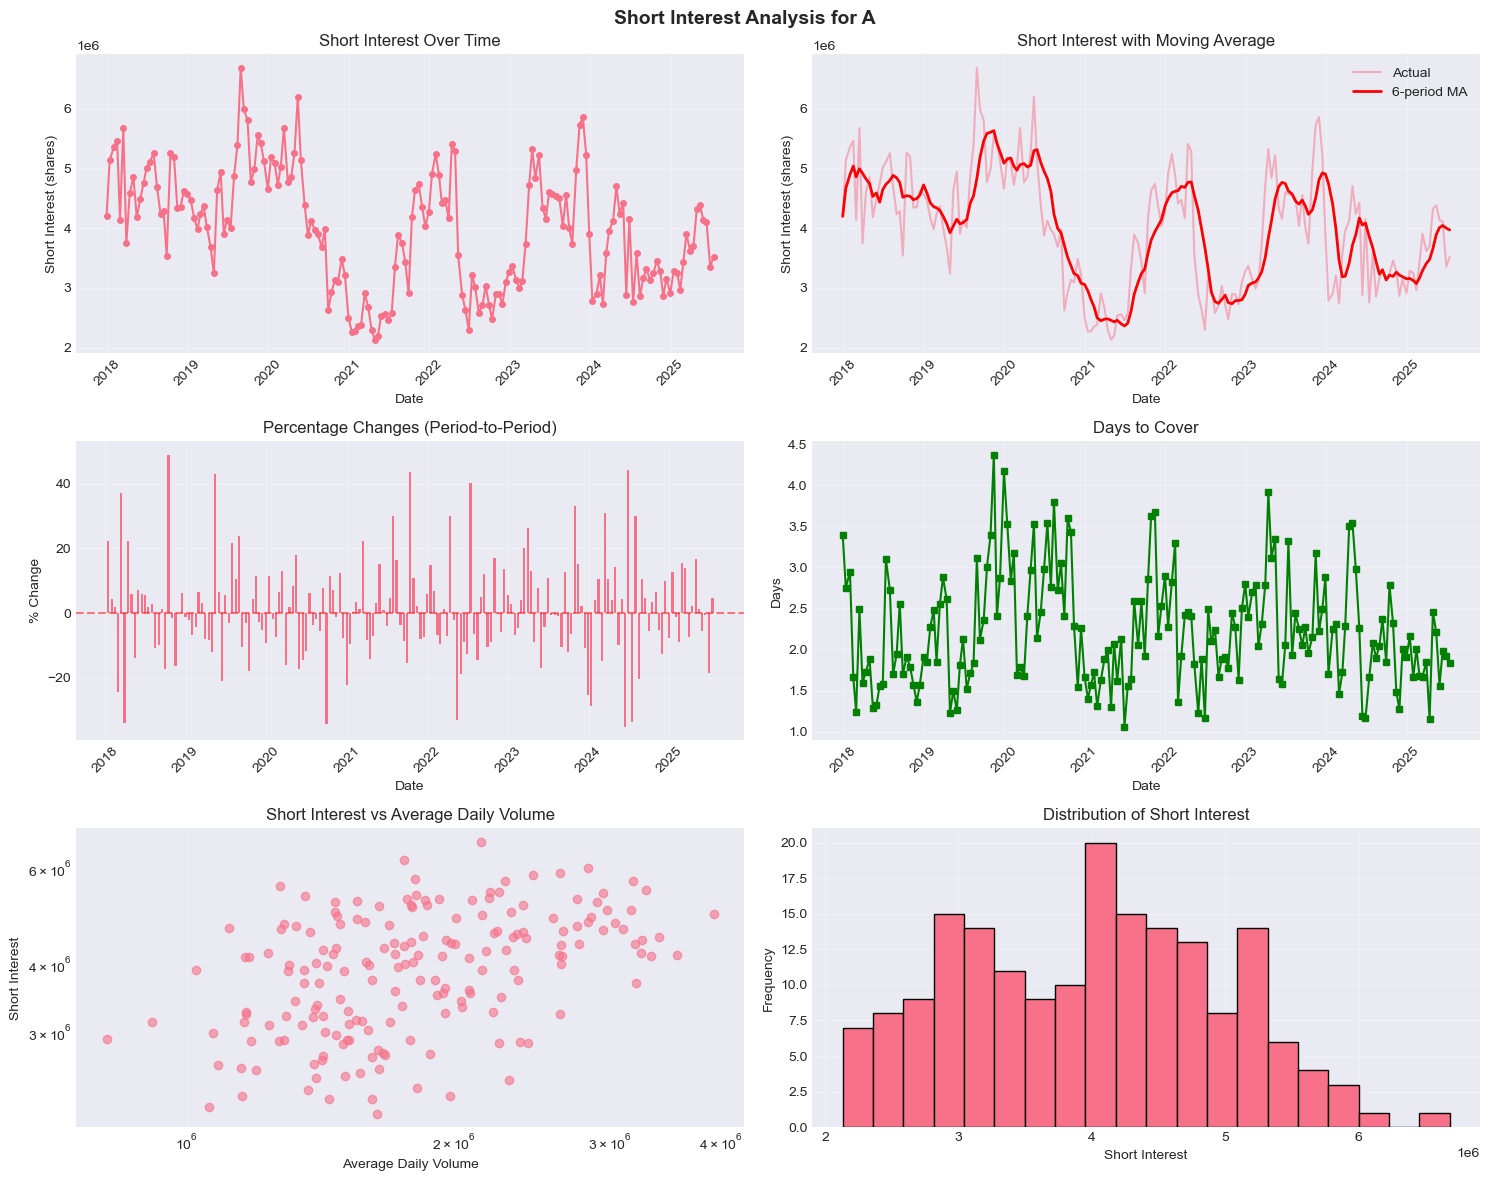

In [32]:
# Analyze one symbol in detail
symbol = most_complete_symbol
symbol_data = data[data['symbolCode'] == symbol].sort_values('settlementDate')

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle(f'Short Interest Analysis for {symbol}', fontsize=14, fontweight='bold')

# 1. Short interest over time
ax = axes[0, 0]
ax.plot(symbol_data['settlementDate'], symbol_data['currentShortPositionQuantity'], 
        marker='o', markersize=4, linewidth=1.5)
ax.set_title('Short Interest Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Short Interest (shares)')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# 2. Short interest with moving average
ax = axes[0, 1]
ax.plot(symbol_data['settlementDate'], symbol_data['currentShortPositionQuantity'], 
        alpha=0.5, label='Actual')
# Calculate moving average (approximately 3 months = 6 observations)
symbol_data['ma_6'] = symbol_data['currentShortPositionQuantity'].rolling(window=6, min_periods=1).mean()
ax.plot(symbol_data['settlementDate'], symbol_data['ma_6'], 
        linewidth=2, label='6-period MA', color='red')
ax.set_title('Short Interest with Moving Average')
ax.set_xlabel('Date')
ax.set_ylabel('Short Interest (shares)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# 3. Percentage changes
ax = axes[1, 0]
pct_changes = symbol_data['currentShortPositionQuantity'].pct_change() * 100
ax.bar(symbol_data['settlementDate'].iloc[1:], pct_changes.iloc[1:], width=10)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_title('Percentage Changes (Period-to-Period)')
ax.set_xlabel('Date')
ax.set_ylabel('% Change')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# 4. Days to cover
ax = axes[1, 1]
ax.plot(symbol_data['settlementDate'], symbol_data['daysToCoverQuantity'], 
        marker='s', markersize=4, linewidth=1.5, color='green')
ax.set_title('Days to Cover')
ax.set_xlabel('Date')
ax.set_ylabel('Days')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# 5. Short interest vs volume relationship
ax = axes[2, 0]
ax.scatter(symbol_data['averageDailyVolumeQuantity'], 
          symbol_data['currentShortPositionQuantity'], alpha=0.6)
ax.set_title('Short Interest vs Average Daily Volume')
ax.set_xlabel('Average Daily Volume')
ax.set_ylabel('Short Interest')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# 6. Distribution of short interest for this symbol
ax = axes[2, 1]
ax.hist(symbol_data['currentShortPositionQuantity'].dropna(), bins=20, edgecolor='black')
ax.set_title(f'Distribution of Short Interest')
ax.set_xlabel('Short Interest')
ax.set_ylabel('Frequency')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

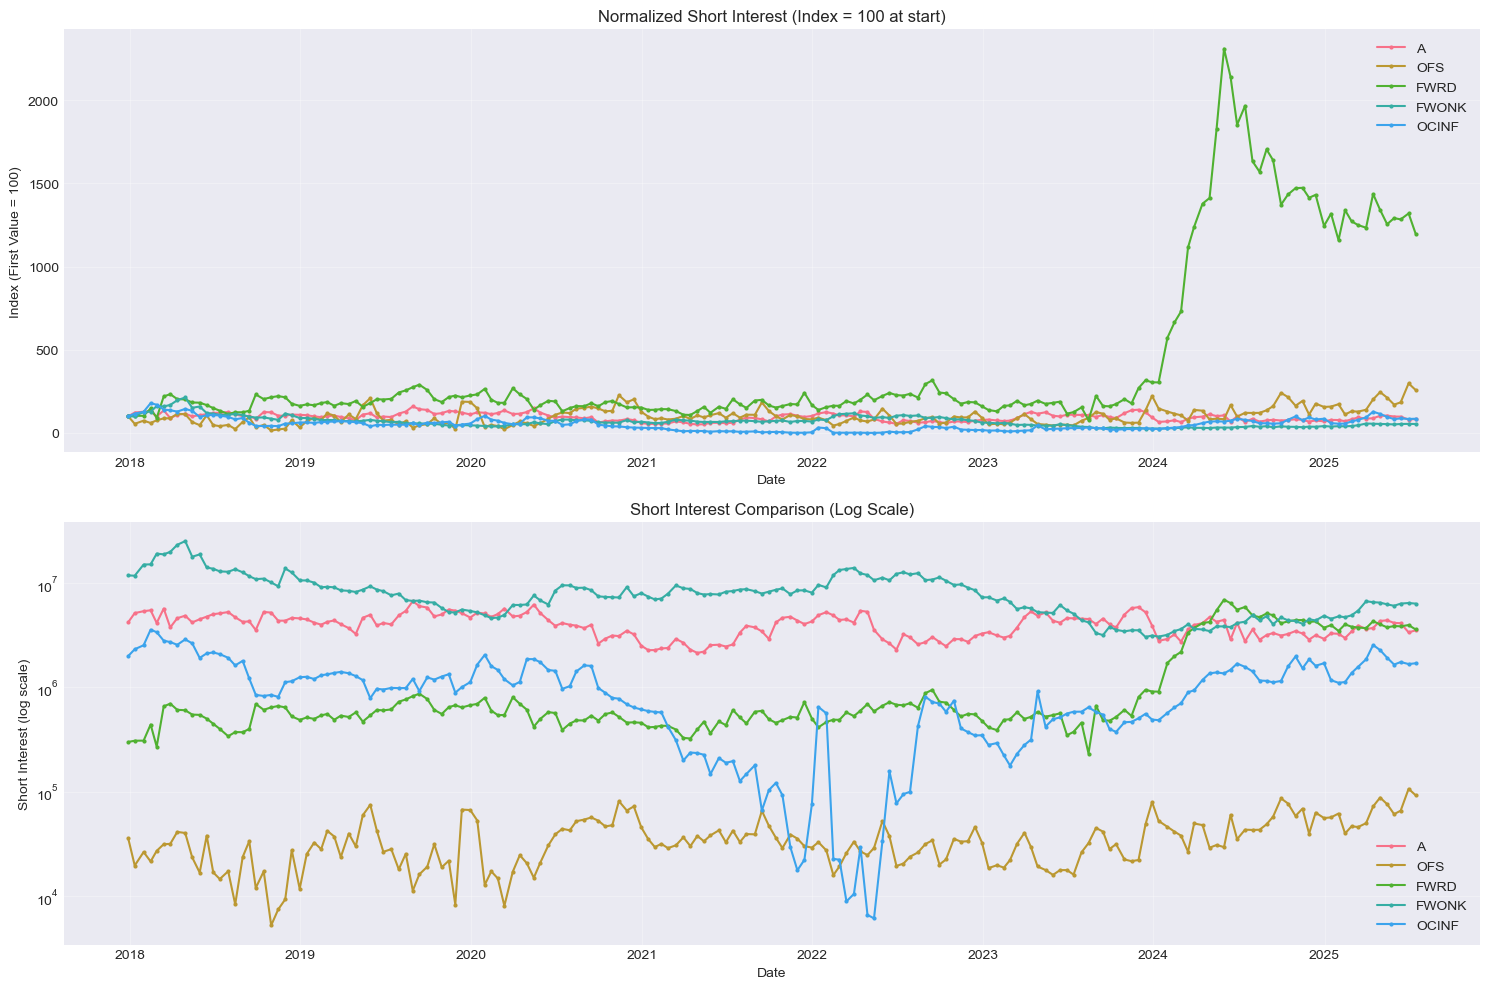

In [33]:
# Compare top 10 symbols by data coverage
top_10_symbols = data_coverage.head(10).index.tolist()

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Normalized short interest (divide by first non-null value)
ax = axes[0]
for symbol in top_10_symbols[:5]:  # Plot only 5 for clarity
    series = short_interest[symbol].dropna()
    if len(series) > 0:
        normalized = series / series.iloc[0] * 100
        ax.plot(normalized.index, normalized, label=symbol, marker='o', markersize=2)

ax.set_title('Normalized Short Interest (Index = 100 at start)')
ax.set_xlabel('Date')
ax.set_ylabel('Index (First Value = 100)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot 2: Actual values on log scale
ax = axes[1]
for symbol in top_10_symbols[:5]:
    series = short_interest[symbol].dropna()
    if len(series) > 0:
        ax.semilogy(series.index, series, label=symbol, marker='o', markersize=2)

ax.set_title('Short Interest Comparison (Log Scale)')
ax.set_xlabel('Date')
ax.set_ylabel('Short Interest (log scale)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

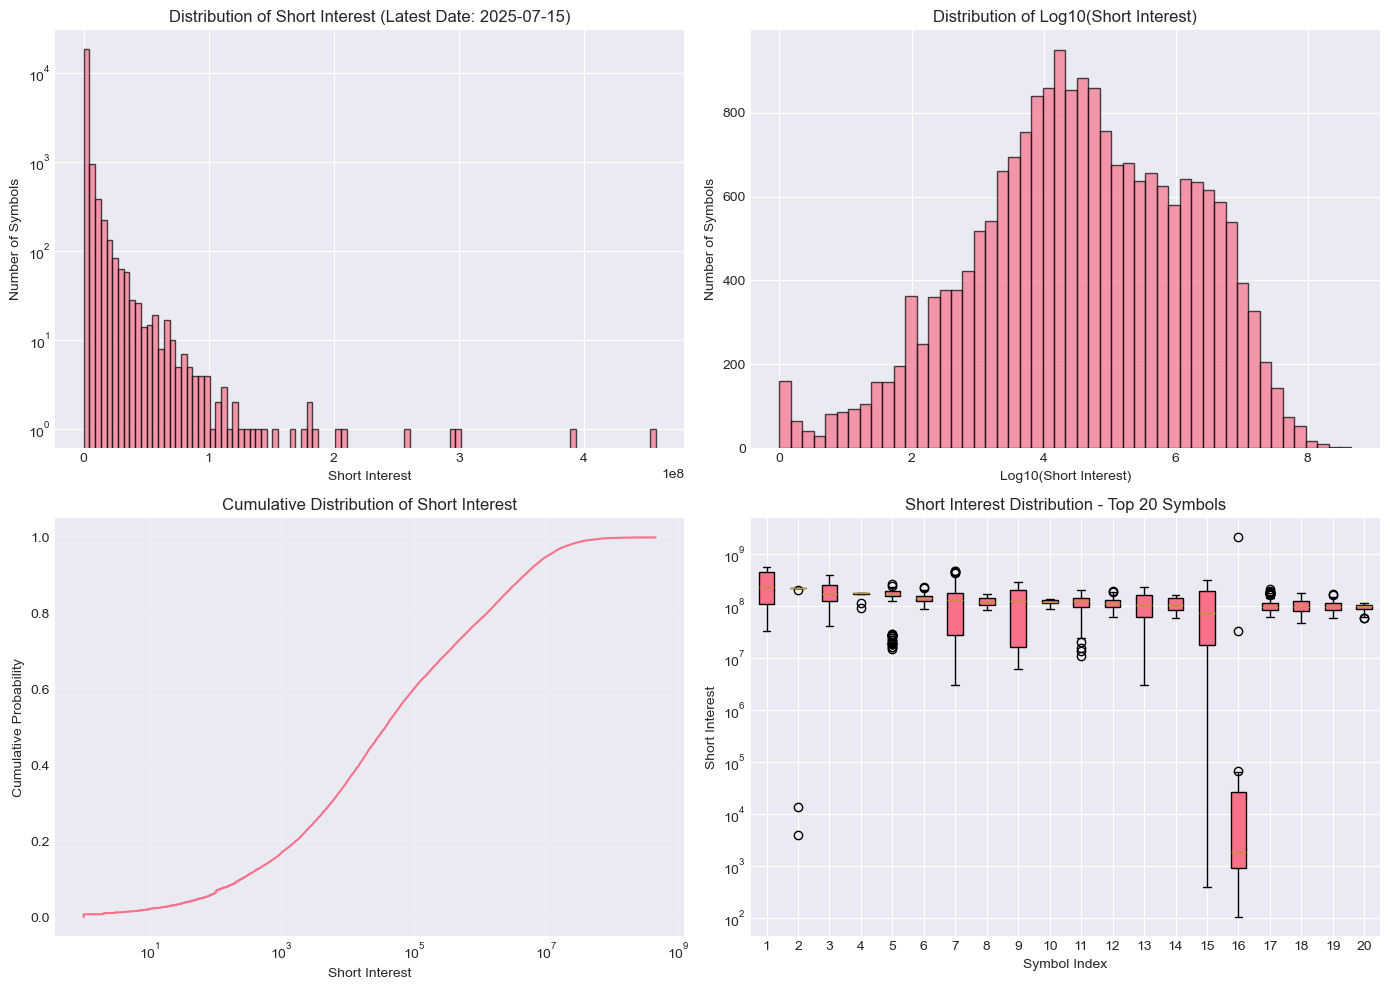


Short Interest Percentiles (Latest Date):
  1th percentile:               2 shares
  5th percentile:              61 shares
 10th percentile:             240 shares
 25th percentile:           3,086 shares
 50th percentile:          36,865 shares
 75th percentile:         638,142 shares
 90th percentile:       4,685,148 shares
 95th percentile:      10,150,027 shares
 99th percentile:      35,391,465 shares


In [34]:
# Get latest observation for each symbol
latest_date = short_interest.index[-1]
latest_values = short_interest.loc[latest_date].dropna()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of latest short interest values
ax = axes[0, 0]
ax.hist(latest_values, bins=100, edgecolor='black', alpha=0.7)
ax.set_title(f'Distribution of Short Interest (Latest Date: {latest_date.date()})')
ax.set_xlabel('Short Interest')
ax.set_ylabel('Number of Symbols')
ax.set_yscale('log')

# 2. Log histogram
ax = axes[0, 1]
log_values = np.log10(latest_values[latest_values > 0])
ax.hist(log_values, bins=50, edgecolor='black', alpha=0.7)
ax.set_title('Distribution of Log10(Short Interest)')
ax.set_xlabel('Log10(Short Interest)')
ax.set_ylabel('Number of Symbols')

# 3. Cumulative distribution
ax = axes[1, 0]
sorted_values = np.sort(latest_values)
cumulative = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
ax.plot(sorted_values, cumulative)
ax.set_title('Cumulative Distribution of Short Interest')
ax.set_xlabel('Short Interest')
ax.set_ylabel('Cumulative Probability')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# 4. Box plot of top 20 symbols
ax = axes[1, 1]
top_20_symbols = symbol_means.head(20).index
box_data = [short_interest[symbol].dropna() for symbol in top_20_symbols]
bp = ax.boxplot(box_data, vert=True, patch_artist=True)
ax.set_title('Short Interest Distribution - Top 20 Symbols')
ax.set_xlabel('Symbol Index')
ax.set_ylabel('Short Interest')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

# Print percentile statistics
print("\nShort Interest Percentiles (Latest Date):")
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = np.percentile(latest_values, p)
    print(f"{p:3d}th percentile: {value:15,.0f} shares")


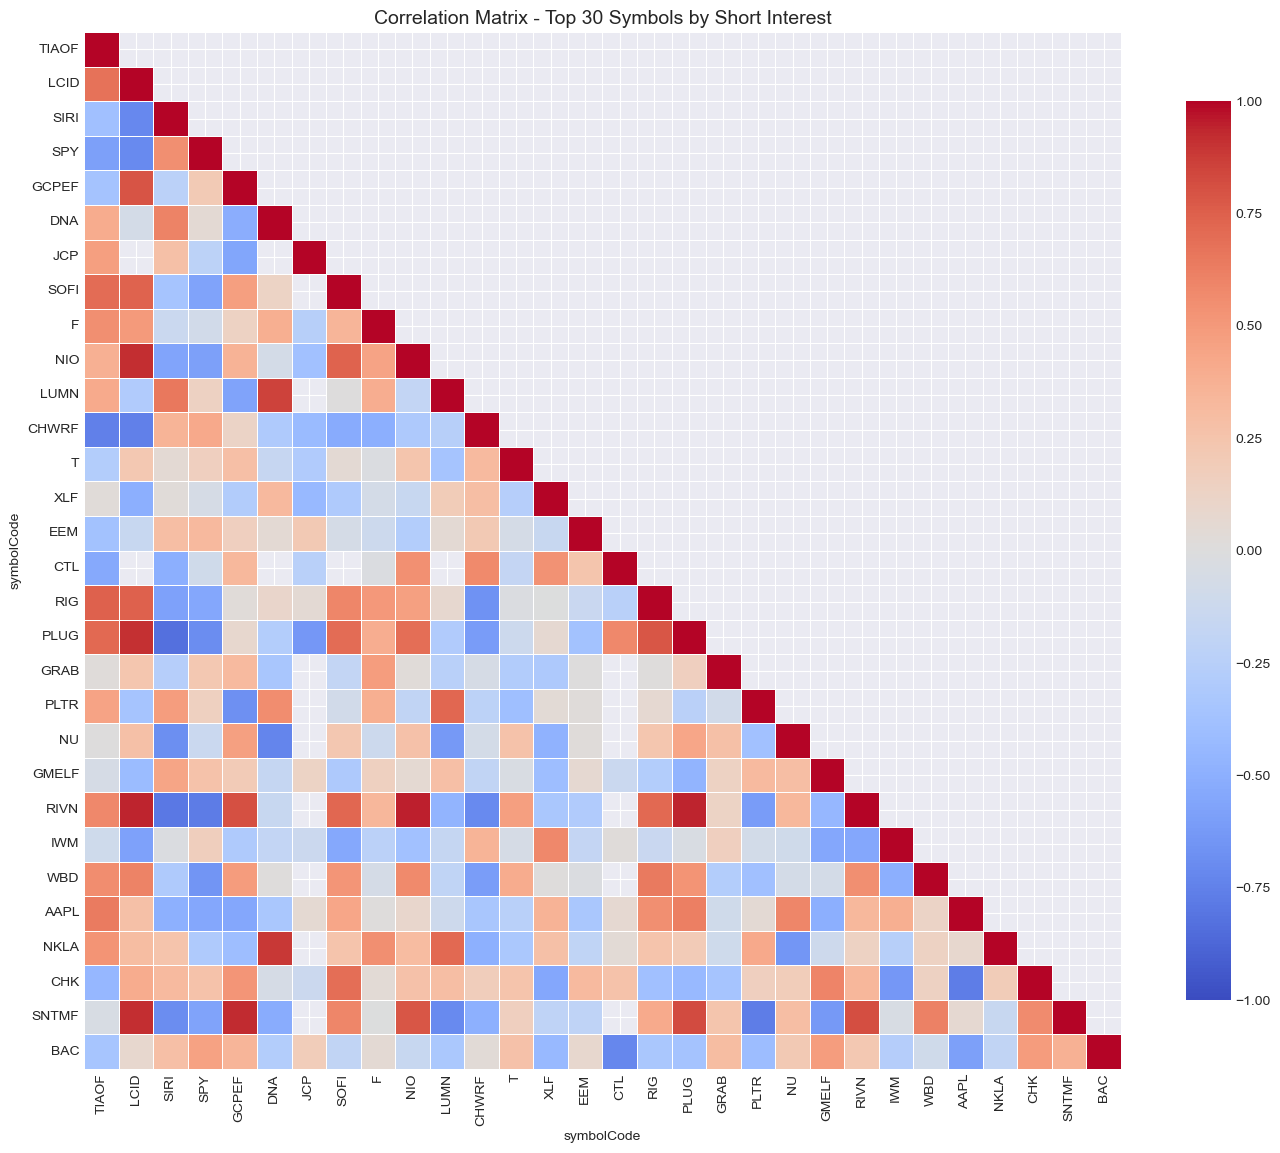


Correlation Statistics (n=30 symbols):
Mean correlation: nan
Median correlation: nan
Min correlation: nan
Max correlation: nan
% of correlations > 0.5: 13.8%
% of correlations > 0.7: 6.0%


In [35]:
# Select symbols with sufficient data for correlation
min_observations = 40
valid_for_corr = data_coverage[data_coverage >= min_observations].index

# Get top 30 by average short interest
top_30_for_corr = short_interest[valid_for_corr].mean().nlargest(30).index

# Calculate correlation matrix
corr_matrix = short_interest[top_30_for_corr].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix), k=1)
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Correlation Matrix - Top 30 Symbols by Short Interest', fontsize=14)
plt.tight_layout()
plt.show()

# Calculate and show correlation statistics
corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
print(f"\nCorrelation Statistics (n={len(top_30_for_corr)} symbols):")
print(f"Mean correlation: {np.mean(corr_values):.3f}")
print(f"Median correlation: {np.median(corr_values):.3f}")
print(f"Min correlation: {np.min(corr_values):.3f}")
print(f"Max correlation: {np.max(corr_values):.3f}")
print(f"% of correlations > 0.5: {(corr_values > 0.5).mean() * 100:.1f}%")
print(f"% of correlations > 0.7: {(corr_values > 0.7).mean() * 100:.1f}%")


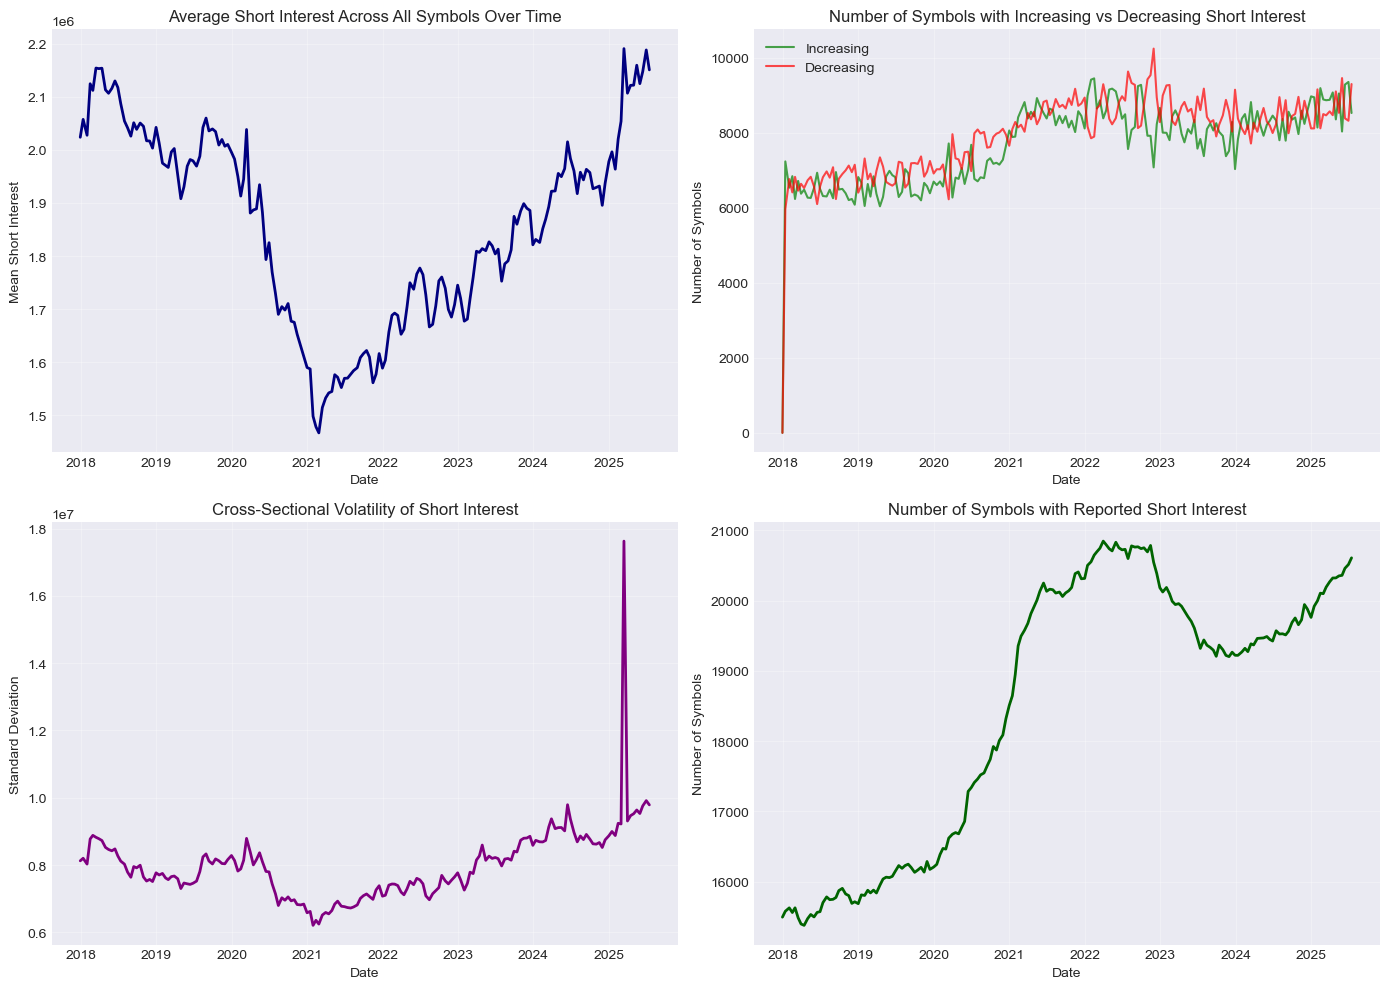

In [36]:
# Analyze patterns over time
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Average short interest over time
ax = axes[0, 0]
mean_si_over_time = short_interest.mean(axis=1)
ax.plot(mean_si_over_time.index, mean_si_over_time, linewidth=2, color='navy')
ax.set_title('Average Short Interest Across All Symbols Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Short Interest')
ax.grid(True, alpha=0.3)

# 2. Number of symbols with increasing vs decreasing SI
ax = axes[0, 1]
changes = short_interest.diff()
increasing = (changes > 0).sum(axis=1)
decreasing = (changes < 0).sum(axis=1)
ax.plot(changes.index, increasing, label='Increasing', color='green', alpha=0.7)
ax.plot(changes.index, decreasing, label='Decreasing', color='red', alpha=0.7)
ax.set_title('Number of Symbols with Increasing vs Decreasing Short Interest')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Symbols')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Volatility over time (std across symbols)
ax = axes[1, 0]
std_si_over_time = short_interest.std(axis=1)
ax.plot(std_si_over_time.index, std_si_over_time, linewidth=2, color='purple')
ax.set_title('Cross-Sectional Volatility of Short Interest')
ax.set_xlabel('Date')
ax.set_ylabel('Standard Deviation')
ax.grid(True, alpha=0.3)

# 4. Market coverage
ax = axes[1, 1]
coverage = short_interest.notna().sum(axis=1)
ax.plot(coverage.index, coverage, linewidth=2, color='darkgreen')
ax.set_title('Number of Symbols with Reported Short Interest')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Symbols')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Statistical Outlier Detection Methods

In [37]:
def detect_outliers_for_symbol(series, method='mad', threshold=3.5):
    """
    Detect outliers within a single stock's time series.
    Each stock has its own distribution and normal range.
    """
    clean_series = series.dropna()
    
    if len(clean_series) < 10:  # Need minimum data
        return pd.Series(False, index=series.index), {}
    
    if method == 'mad':
        # Median Absolute Deviation - robust to outliers
        median = clean_series.median()
        mad = np.median(np.abs(clean_series - median))
        if mad == 0:
            return pd.Series(False, index=series.index), {}
        
        modified_z_scores = 0.6745 * (clean_series - median) / mad
        outliers = np.abs(modified_z_scores) > threshold
        
        info = {
            'median': median,
            'mad': mad,
            'lower_bound': median - threshold * mad / 0.6745,
            'upper_bound': median + threshold * mad / 0.6745
        }
        
    elif method == 'iqr':
        # Interquartile Range
        Q1 = clean_series.quantile(0.25)
        Q3 = clean_series.quantile(0.75)
        IQR = Q3 - Q1
        
        multiplier = threshold  # Use threshold as IQR multiplier
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        outliers = (clean_series < lower_bound) | (clean_series > upper_bound)
        
        info = {
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
        
    elif method == 'zscore':
        # Z-score (assumes normal distribution)
        mean = clean_series.mean()
        std = clean_series.std()
        
        if std == 0:
            return pd.Series(False, index=series.index), {}
        
        z_scores = np.abs((clean_series - mean) / std)
        outliers = z_scores > threshold
        
        info = {
            'mean': mean,
            'std': std,
            'lower_bound': mean - threshold * std,
            'upper_bound': mean + threshold * std
        }
    
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Return full series with NaN preserved
    outlier_series = pd.Series(False, index=series.index)
    outlier_series[outliers.index] = outliers
    
    return outlier_series, info


In [38]:
# Get short interest data
short_interest = wide_data['currentShortPositionQuantity']

print("STOCK-LEVEL OUTLIER DETECTION")
print("=" * 60)
print(f"Total number of stocks: {len(short_interest.columns)}")

# Process all stocks
outlier_results = {}
outlier_summary = []

for symbol in short_interest.columns:
    symbol_data = short_interest[symbol]
    
    # Detect outliers using MAD method
    outliers_mad, info_mad = detect_outliers_for_symbol(symbol_data, method='mad', threshold=3.5)
    
    # Also try IQR for comparison
    outliers_iqr, info_iqr = detect_outliers_for_symbol(symbol_data, method='iqr', threshold=1.5)
    
    n_observations = symbol_data.notna().sum()
    
    if n_observations >= 10:  # Only include stocks with sufficient data
        outlier_results[symbol] = {
            'data': symbol_data,
            'outliers_mad': outliers_mad,
            'outliers_iqr': outliers_iqr,
            'info_mad': info_mad,
            'info_iqr': info_iqr
        }
        
        outlier_summary.append({
            'symbol': symbol,
            'n_observations': n_observations,
            'n_outliers_mad': outliers_mad.sum(),
            'n_outliers_iqr': outliers_iqr.sum(),
            'pct_outliers_mad': outliers_mad.mean() * 100,
            'pct_outliers_iqr': outliers_iqr.mean() * 100,
            'mean': symbol_data.mean(),
            'median': symbol_data.median(),
            'std': symbol_data.std(),
            'cv': symbol_data.std() / symbol_data.mean() if symbol_data.mean() != 0 else np.nan
        })

# Create summary DataFrame
outlier_summary_df = pd.DataFrame(outlier_summary)
outlier_summary_df = outlier_summary_df.sort_values('n_outliers_mad', ascending=False)

print(f"Stocks analyzed (with >= 10 observations): {len(outlier_summary_df)}")
print(f"Stocks with MAD outliers: {(outlier_summary_df['n_outliers_mad'] > 0).sum()}")
print(f"Stocks with IQR outliers: {(outlier_summary_df['n_outliers_iqr'] > 0).sum()}")

print("\nTop 10 Stocks by Number of MAD Outliers:")
print(outlier_summary_df[['symbol', 'n_observations', 'n_outliers_mad', 'pct_outliers_mad', 'cv']].head(10))


STOCK-LEVEL OUTLIER DETECTION
Total number of stocks: 44673
Stocks analyzed (with >= 10 observations): 37831
Stocks with MAD outliers: 28305
Stocks with IQR outliers: 29348

Top 10 Stocks by Number of MAD Outliers:
      symbol  n_observations  n_outliers_mad  pct_outliers_mad        cv
23746  NMMCF             181              89         48.901099  0.807311
10664   EMMS             182              88         48.351648  2.225686
15849   HMNY             182              87         47.802198  3.081055
13666     GE             182              87         47.802198  0.873316
23076   NAUH             182              87         47.802198  2.543583
32073  STMZF             175              86         47.252747  1.315102
17600  IPHYF             179              86         47.252747  1.032763
5981   CDVIQ             182              86         47.252747  0.384657
18792  JRJRQ             169              84         46.153846  0.820189
20926   LWLG             182              82         45

In [39]:
# Check if outliers occur on same dates across multiple stocks
outlier_dates = {}

for symbol, results in outlier_results.items():
    outlier_mask = results['outliers_mad']
    outlier_dates_symbol = results['data'].index[outlier_mask]
    
    for date in outlier_dates_symbol:
        if date not in outlier_dates:
            outlier_dates[date] = []
        outlier_dates[date].append(symbol)

# Sort dates by number of stocks with outliers
outlier_dates_summary = [(date, len(symbols)) for date, symbols in outlier_dates.items()]
outlier_dates_summary.sort(key=lambda x: x[1], reverse=True)

print("\nDates with Most Outliers Across Stocks:")
print("Date                 | Number of Stocks with Outliers")
print("-" * 50)
for date, count in outlier_dates_summary[:10]:
    print(f"{date.date()}      | {count}")

# Check if certain dates have systematic outliers (market-wide events)
threshold_for_systematic = 50  # If more than 50 stocks have outliers on same date
systematic_dates = [date for date, count in outlier_dates_summary if count > threshold_for_systematic]

if systematic_dates:
    print(f"\nPotential market-wide events (>{threshold_for_systematic} stocks with outliers):")
    for date in systematic_dates[:5]:
        print(f"  {date.date()}: {len(outlier_dates[date])} stocks affected")



Dates with Most Outliers Across Stocks:
Date                 | Number of Stocks with Outliers
--------------------------------------------------
2025-07-15      | 3282
2025-06-30      | 3169
2025-06-13      | 2945
2025-05-15      | 2867
2025-04-15      | 2837
2025-05-30      | 2784
2025-04-30      | 2721
2025-02-28      | 2665
2025-03-14      | 2662
2025-03-31      | 2656

Potential market-wide events (>50 stocks with outliers):
  2025-07-15: 3282 stocks affected
  2025-06-30: 3169 stocks affected
  2025-06-13: 2945 stocks affected
  2025-05-15: 2867 stocks affected
  2025-04-15: 2837 stocks affected


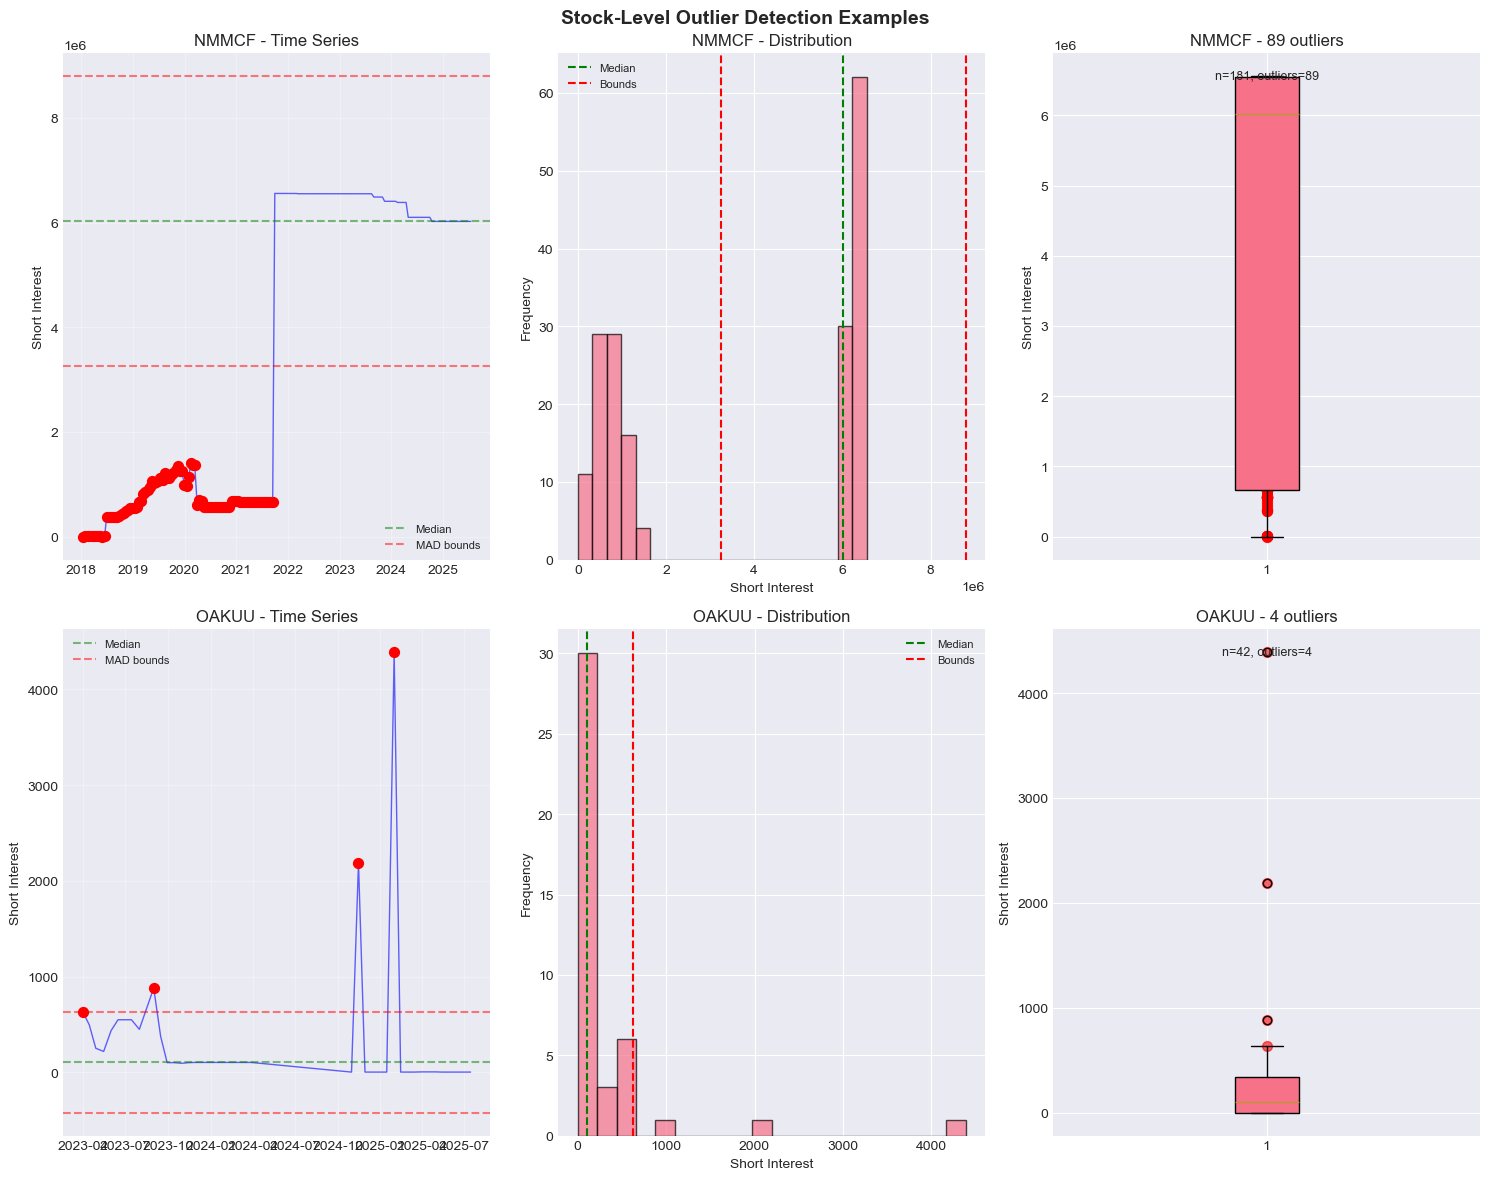

In [40]:
# Select diverse examples
examples = {
    'high_outliers': outlier_summary_df.iloc[0]['symbol'],  # Most outliers
    'typical': outlier_summary_df.iloc[len(outlier_summary_df)//2]['symbol'],  # Middle
}

# Visualize example stocks
fig, axes = plt.subplots(2, 3, figsize=(15, 12))

for idx, (example_type, symbol) in enumerate(examples.items()):
    if symbol is None:
        continue
        
    results = outlier_results[symbol]
    data = results['data'].dropna()
    outliers_mad = results['outliers_mad'][data.index]
    info = results['info_mad']
    
    # Time series with outliers
    ax = axes[idx, 0]
    ax.plot(data.index, data.values, 'b-', alpha=0.6, linewidth=1)
    outlier_points = data[outliers_mad]
    if len(outlier_points) > 0:
        ax.scatter(outlier_points.index, outlier_points.values, color='red', s=50, zorder=5)
    ax.axhline(y=info['median'], color='green', linestyle='--', alpha=0.5, label='Median')
    ax.axhline(y=info['upper_bound'], color='red', linestyle='--', alpha=0.5, label='MAD bounds')
    ax.axhline(y=info['lower_bound'], color='red', linestyle='--', alpha=0.5)
    ax.set_title(f'{symbol} - Time Series')
    ax.set_ylabel('Short Interest')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Distribution
    ax = axes[idx, 1]
    ax.hist(data.values, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(x=info['median'], color='green', linestyle='--', label='Median')
    ax.axvline(x=info['upper_bound'], color='red', linestyle='--', label='Bounds')
    if info['lower_bound'] > 0:
        ax.axvline(x=info['lower_bound'], color='red', linestyle='--')
    ax.set_title(f'{symbol} - Distribution')
    ax.set_xlabel('Short Interest')
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=8)
    
    # Box plot
    ax = axes[idx, 2]
    bp = ax.boxplot(data.values, vert=True, patch_artist=True)
    if len(outlier_points) > 0:
        ax.scatter(np.ones(len(outlier_points)), outlier_points.values, 
                  color='red', s=50, alpha=0.6)
    ax.set_title(f'{symbol} - {len(outlier_points)} outliers')
    ax.set_ylabel('Short Interest')
    
    # Add text summary
    ax.text(0.5, 0.95, f"n={len(data)}, outliers={len(outlier_points)}", 
           transform=ax.transAxes, ha='center', fontsize=9)

fig.suptitle('Stock-Level Outlier Detection Examples', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [41]:
# What makes a stock prone to outliers?
print("\nCHARACTERISTICS OF STOCKS WITH MANY OUTLIERS")
print("=" * 60)

# Compare high-outlier stocks vs low-outlier stocks
high_outlier_stocks = outlier_summary_df[outlier_summary_df['n_outliers_mad'] >= 3]
low_outlier_stocks = outlier_summary_df[outlier_summary_df['n_outliers_mad'] == 0]

print(f"High-outlier stocks (>=3 outliers): {len(high_outlier_stocks)}")
print(f"  Average CV: {high_outlier_stocks['cv'].mean():.3f}")
print(f"  Average observations: {high_outlier_stocks['n_observations'].mean():.1f}")

print(f"\nNo-outlier stocks: {len(low_outlier_stocks)}")
print(f"  Average CV: {low_outlier_stocks['cv'].mean():.3f}")
print(f"  Average observations: {low_outlier_stocks['n_observations'].mean():.1f}")

# Correlation between volatility and outliers
correlation = outlier_summary_df[['cv', 'pct_outliers_mad']].corr().iloc[0, 1]
print(f"\nCorrelation between CV and outlier percentage: {correlation:.3f}")



CHARACTERISTICS OF STOCKS WITH MANY OUTLIERS
High-outlier stocks (>=3 outliers): 22924
  Average CV: 1.535
  Average observations: 99.1

No-outlier stocks: 9526
  Average CV: 0.789
  Average observations: 77.9

Correlation between CV and outlier percentage: 0.267


In [42]:
def create_stock_outlier_report(symbol, results):
    """
    Create detailed outlier report for a single stock.
    """
    data = results['data'].dropna()
    outliers_mad = results['outliers_mad'][data.index]
    info = results['info_mad']
    
    outlier_points = data[outliers_mad]
    
    if len(outlier_points) == 0:
        return None
    
    report = {
        'symbol': symbol,
        'total_observations': len(data),
        'n_outliers': len(outlier_points),
        'pct_outliers': len(outlier_points) / len(data) * 100,
        'median': info['median'],
        'mad': info['mad'],
        'bounds': (info['lower_bound'], info['upper_bound']),
        'outlier_dates': outlier_points.index.tolist(),
        'outlier_values': outlier_points.values.tolist(),
        'outlier_deviations': [(val - info['median']) / info['median'] * 100 
                               for val in outlier_points.values]
    }
    
    return report

# Generate reports for stocks with outliers
outlier_reports = []
for symbol in outlier_summary_df[outlier_summary_df['n_outliers_mad'] > 0]['symbol'].head(100):
    report = create_stock_outlier_report(symbol, outlier_results[symbol])
    if report:
        outlier_reports.append(report)

# Create detailed DataFrame
detailed_outliers = []
for report in outlier_reports:
    for i, (date, value, dev) in enumerate(zip(report['outlier_dates'], 
                                               report['outlier_values'], 
                                               report['outlier_deviations'])):
        detailed_outliers.append({
            'symbol': report['symbol'],
            'date': date,
            'short_interest': value,
            'median': report['median'],
            'pct_deviation': dev,
            'bounds': report['bounds']
        })

detailed_outliers_df = pd.DataFrame(detailed_outliers)
detailed_outliers_df = detailed_outliers_df.sort_values('pct_deviation', ascending=False)

print("\nMOST EXTREME OUTLIERS (by % deviation from stock's median):")
print(detailed_outliers_df.head(15)[['symbol', 'date', 'short_interest', 'median', 'pct_deviation']])


MOST EXTREME OUTLIERS (by % deviation from stock's median):
     symbol       date  short_interest  median  pct_deviation
5866   TGHI 2023-02-15       1700001.0     2.0     84999950.0
5865   TGHI 2023-01-31       1700001.0     2.0     84999950.0
5862   TGHI 2022-11-15        569861.0     2.0     28492950.0
5872   TGHI 2023-06-15        528959.0     2.0     26447850.0
5870   TGHI 2023-05-15        528959.0     2.0     26447850.0
5868   TGHI 2023-04-14        528959.0     2.0     26447850.0
5867   TGHI 2023-03-31        528959.0     2.0     26447850.0
5873   TGHI 2023-06-30        528959.0     2.0     26447850.0
5869   TGHI 2023-04-28        528959.0     2.0     26447850.0
5871   TGHI 2023-05-31        528959.0     2.0     26447850.0
5230   CGAC 2023-12-15       2000938.0    10.0     20009280.0
5231   CGAC 2023-12-29       2000938.0    10.0     20009280.0
5856   TGHI 2022-06-30        179173.0     2.0      8958550.0
5844   TGHI 2021-11-30        159281.0     2.0      7963950.0
5226   CG

## Time Series Analysis

In [45]:
# Get short interest data
short_interest = wide_data['currentShortPositionQuantity']

# Find stocks with sufficient data for time series analysis
min_observations_required = 30
data_coverage = short_interest.notna().sum().sort_values(ascending=False)
valid_stocks = data_coverage[data_coverage >= min_observations_required].index.tolist()

print(f"Total stocks with >= {min_observations_required} observations: {len(valid_stocks)}")

# Select diverse examples for detailed analysis
# 1. Most complete data
most_complete = data_coverage.index[0]

# 2. High volume stock
high_volume = short_interest[valid_stocks].mean().nlargest(50).index[0]

# 3. Random medium-sized stock
medium_stock = valid_stocks[len(valid_stocks)//2]

example_stocks = [most_complete, high_volume, medium_stock]
print(f"\nExample stocks for detailed analysis:")
for stock in example_stocks:
    print(f"  {stock}: {data_coverage[stock]} observations, mean SI: {short_interest[stock].mean():,.0f}")


Total stocks with >= 30 observations: 30177

Example stocks for detailed analysis:
  A: 182 observations, mean SI: 3,985,454
  TIAOF: 182 observations, mean SI: 277,501,915
  ADWYF: 95 observations, mean SI: 88,753


In [47]:
def perform_stationarity_tests(series, stock_name):
    """
    Perform comprehensive stationarity tests on a time series.
    """
    # Clean the series
    clean_series = series.dropna()
    
    if len(clean_series) < 20:
        return None
    
    results = {
        'stock': stock_name,
        'n_obs': len(clean_series)
    }
    
    # Check if series is constant
    if clean_series.nunique() == 1 or clean_series.std() == 0:
        results['is_constant'] = True
        results['conclusion'] = 'Constant (no variation)'
        results['adf_stationary'] = False
        results['kpss_stationary'] = False
        results['adf_pvalue'] = np.nan
        results['kpss_pvalue'] = np.nan
        return results
    
    results['is_constant'] = False
    
    try:
        # ADF Test (Augmented Dickey-Fuller)
        # Null hypothesis: series has a unit root (non-stationary)
        adf_result = adfuller(clean_series, autolag='AIC')
        results['adf_statistic'] = adf_result[0]
        results['adf_pvalue'] = adf_result[1]
        results['adf_critical_values'] = adf_result[4]
        results['adf_usedlag'] = adf_result[2]
        results['adf_stationary'] = adf_result[1] < 0.05
    except Exception as e:
        results['adf_pvalue'] = np.nan
        results['adf_stationary'] = False
        results['adf_error'] = str(e)
    
    try:
        # KPSS Test
        # Null hypothesis: series is stationary
        kpss_result = kpss(clean_series, regression='c', nlags='auto')
        results['kpss_statistic'] = kpss_result[0]
        results['kpss_pvalue'] = kpss_result[1]
        results['kpss_critical_values'] = kpss_result[3]
        results['kpss_usedlag'] = kpss_result[2]
        results['kpss_stationary'] = kpss_result[1] > 0.05
    except Exception as e:
        results['kpss_pvalue'] = np.nan
        results['kpss_stationary'] = False
        results['kpss_error'] = str(e)
    
    # Conclusion
    if results.get('is_constant'):
        results['conclusion'] = 'Constant'
    elif results.get('adf_stationary') and results.get('kpss_stationary'):
        results['conclusion'] = 'Stationary'
    elif not results.get('adf_stationary') and not results.get('kpss_stationary'):
        results['conclusion'] = 'Non-stationary'
    else:
        results['conclusion'] = 'Ambiguous'
    
    return results

# Test stationarity for all valid stocks
print("STATIONARITY TESTS FOR ALL STOCKS")
print("=" * 60)

stationarity_results = []
for stock in valid_stocks:  # Test first 500 stocks
    series = short_interest[stock]
    result = perform_stationarity_tests(series, stock)
    if result:
        stationarity_results.append(result)

stationarity_df = pd.DataFrame(stationarity_results)

# Summary
print(f"Stocks tested: {len(stationarity_df)}")
print(f"Constant series (no variation): {(stationarity_df['conclusion'] == 'Constant').sum() if 'Constant' in stationarity_df['conclusion'].values else 0}")
print(f"Stationary (both tests agree): {(stationarity_df['conclusion'] == 'Stationary').sum()}")
print(f"Non-stationary (both tests agree): {(stationarity_df['conclusion'] == 'Non-stationary').sum()}")
print(f"Ambiguous (tests disagree): {(stationarity_df['conclusion'] == 'Ambiguous').sum()}")

print("\nExample results (first 10 stocks):")
display_cols = ['stock', 'n_obs', 'adf_pvalue', 'kpss_pvalue', 'conclusion']
display_cols = [col for col in display_cols if col in stationarity_df.columns]
print(stationarity_df[display_cols].head(10))

STATIONARITY TESTS FOR ALL STOCKS
Stocks tested: 30177
Constant series (no variation): 0
Stationary (both tests agree): 10360
Non-stationary (both tests agree): 9636
Ambiguous (tests disagree): 10027

Example results (first 10 stocks):
   stock  n_obs  adf_pvalue  kpss_pvalue      conclusion
0      A    182    0.000487     0.041836       Ambiguous
1    OFS    182    0.000051     0.010000       Ambiguous
2   FWRD    182    0.726890     0.010000  Non-stationary
3  FWONK    182    0.287975     0.010000  Non-stationary
4  OCINF    182    0.032102     0.033975       Ambiguous
5  FWONA    182    0.184750     0.010000  Non-stationary
6  OCLCF    182    0.166499     0.027084  Non-stationary
7  OCLDF    182    0.091653     0.016732  Non-stationary
8    FVD    182    0.271773     0.023690  Non-stationary
9  OCPNF    182    0.106800     0.010000  Non-stationary



TIME SERIES ANALYSIS FOR A
Observations: 182
Date range: 2017-12-29 to 2025-07-15


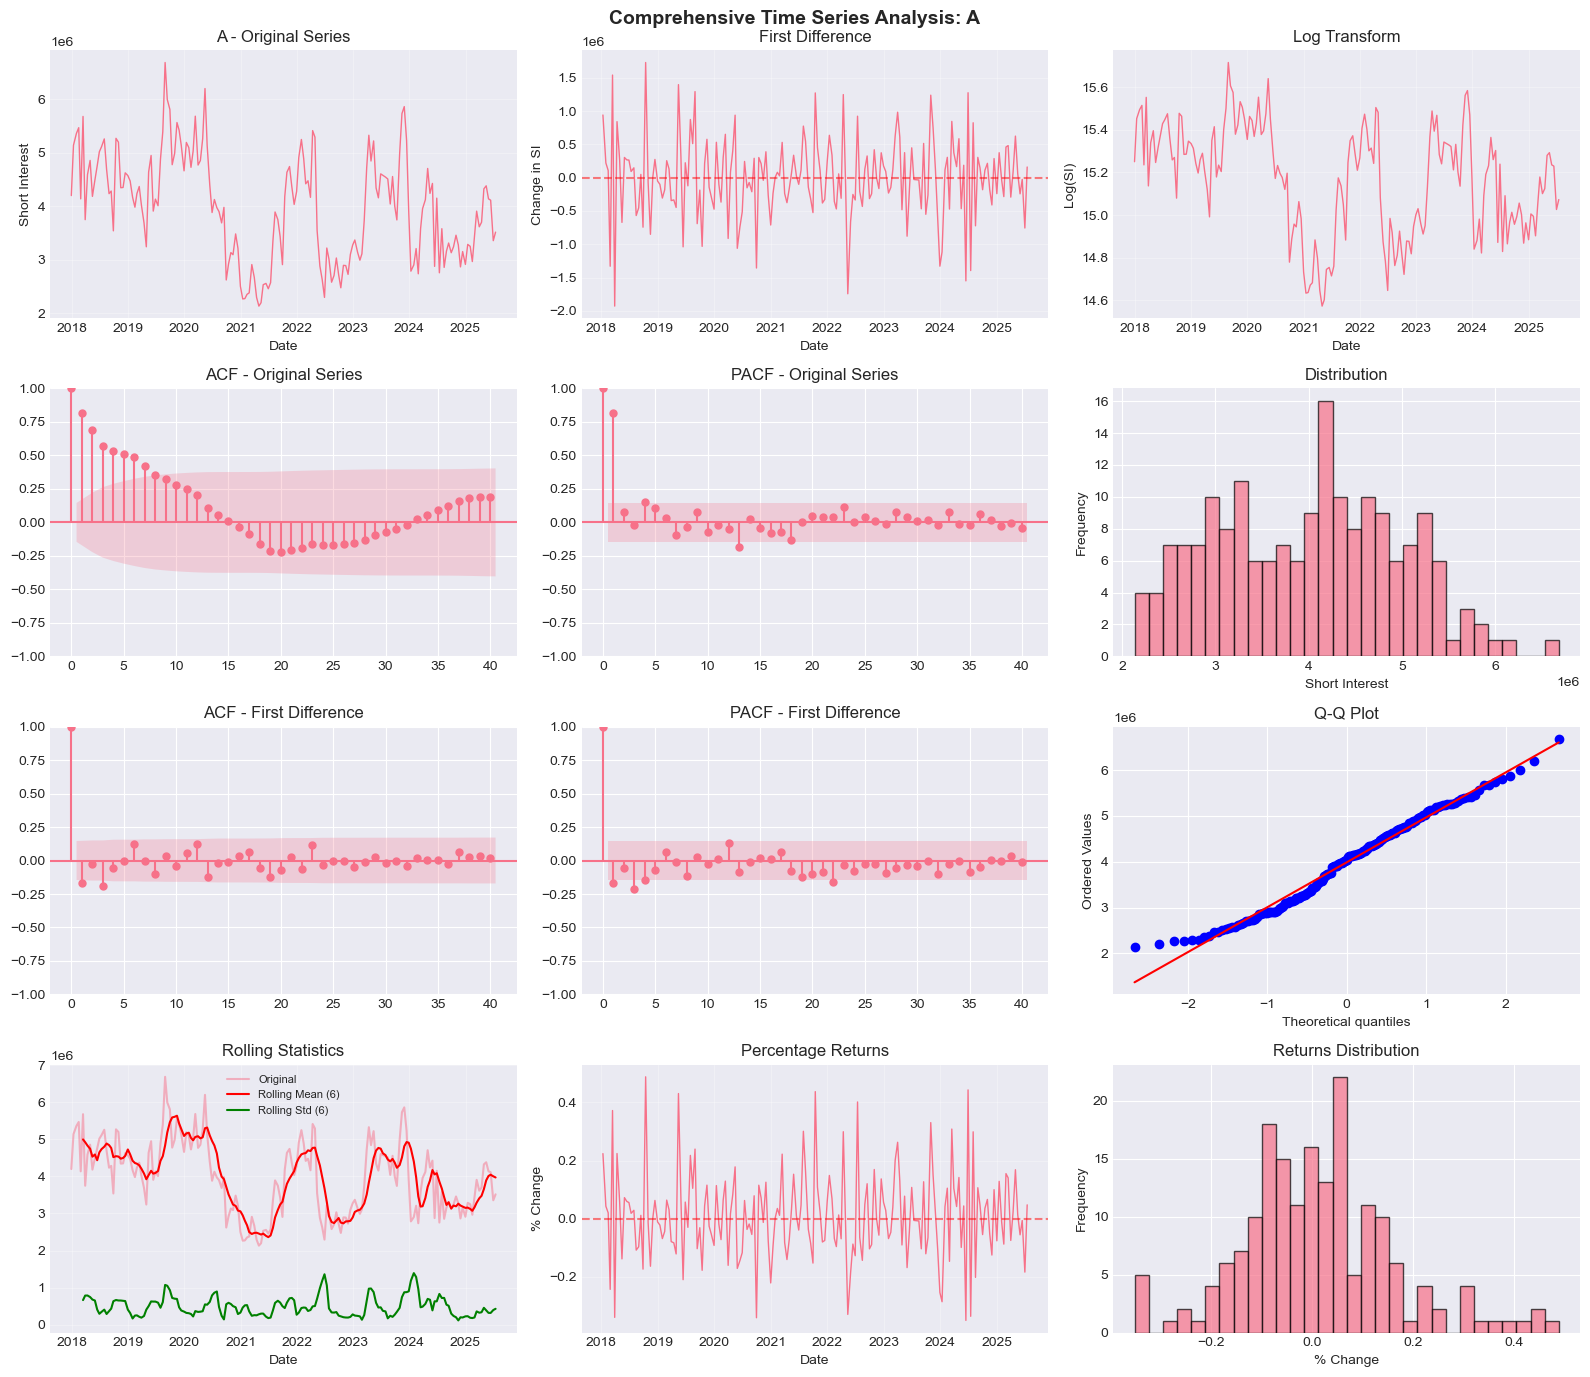

In [48]:
def analyze_stock_time_series(stock_symbol, data):
    """
    Comprehensive time series analysis for a single stock.
    """
    series = data[stock_symbol].dropna()
    
    print(f"\nTIME SERIES ANALYSIS FOR {stock_symbol}")
    print("=" * 60)
    print(f"Observations: {len(series)}")
    print(f"Date range: {series.index[0].date()} to {series.index[-1].date()}")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 14))
    
    # 1. Original Series
    ax1 = plt.subplot(4, 3, 1)
    ax1.plot(series.index, series.values, linewidth=1)
    ax1.set_title(f'{stock_symbol} - Original Series')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Short Interest')
    ax1.grid(True, alpha=0.3)
    
    # 2. First Difference
    diff_series = series.diff().dropna()
    ax2 = plt.subplot(4, 3, 2)
    ax2.plot(diff_series.index, diff_series.values, linewidth=1)
    ax2.set_title('First Difference')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Change in SI')
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    
    # 3. Log Transform
    if (series > 0).all():
        log_series = np.log(series)
        ax3 = plt.subplot(4, 3, 3)
        ax3.plot(log_series.index, log_series.values, linewidth=1)
        ax3.set_title('Log Transform')
        ax3.set_xlabel('Date')
        ax3.set_ylabel('Log(SI)')
        ax3.grid(True, alpha=0.3)
    
    # 4. ACF of Original Series
    ax4 = plt.subplot(4, 3, 4)
    plot_acf(series, lags=min(40, len(series)//2), ax=ax4)
    ax4.set_title('ACF - Original Series')
    
    # 5. PACF of Original Series
    ax5 = plt.subplot(4, 3, 5)
    plot_pacf(series, lags=min(40, len(series)//2), ax=ax5)
    ax5.set_title('PACF - Original Series')
    
    # 6. Distribution
    ax6 = plt.subplot(4, 3, 6)
    ax6.hist(series.values, bins=30, edgecolor='black', alpha=0.7)
    ax6.set_title('Distribution')
    ax6.set_xlabel('Short Interest')
    ax6.set_ylabel('Frequency')
    
    # 7. ACF of First Difference
    ax7 = plt.subplot(4, 3, 7)
    plot_acf(diff_series, lags=min(40, len(diff_series)//2), ax=ax7)
    ax7.set_title('ACF - First Difference')
    
    # 8. PACF of First Difference
    ax8 = plt.subplot(4, 3, 8)
    plot_pacf(diff_series, lags=min(40, len(diff_series)//2), ax=ax8)
    ax8.set_title('PACF - First Difference')
    
    # 9. Q-Q Plot
    ax9 = plt.subplot(4, 3, 9)
    stats.probplot(series.values, dist="norm", plot=ax9)
    ax9.set_title('Q-Q Plot')
    
    # 10. Rolling Statistics
    ax10 = plt.subplot(4, 3, 10)
    rolling_mean = series.rolling(window=6).mean()
    rolling_std = series.rolling(window=6).std()
    ax10.plot(series.index, series.values, label='Original', alpha=0.5)
    ax10.plot(rolling_mean.index, rolling_mean.values, color='red', label='Rolling Mean (6)')
    ax10.plot(rolling_std.index, rolling_std.values, color='green', label='Rolling Std (6)')
    ax10.set_title('Rolling Statistics')
    ax10.set_xlabel('Date')
    ax10.legend(fontsize=8)
    ax10.grid(True, alpha=0.3)
    
    # 11. Percentage Returns
    ax11 = plt.subplot(4, 3, 11)
    returns = series.pct_change().dropna()
    ax11.plot(returns.index, returns.values, linewidth=1)
    ax11.set_title('Percentage Returns')
    ax11.set_xlabel('Date')
    ax11.set_ylabel('% Change')
    ax11.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax11.grid(True, alpha=0.3)
    
    # 12. Returns Distribution
    ax12 = plt.subplot(4, 3, 12)
    ax12.hist(returns.values, bins=30, edgecolor='black', alpha=0.7)
    ax12.set_title('Returns Distribution')
    ax12.set_xlabel('% Change')
    ax12.set_ylabel('Frequency')
    
    plt.suptitle(f'Comprehensive Time Series Analysis: {stock_symbol}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return series, diff_series

# Analyze example stock
example_series, example_diff = analyze_stock_time_series(example_stocks[0], short_interest)


In [49]:
def identify_arima_order(series, stock_name):
    """
    Identify potential ARIMA(p,d,q) order for a series.
    """
    clean_series = series.dropna()
    
    print(f"\nARIMA ORDER IDENTIFICATION FOR {stock_name}")
    print("-" * 50)
    
    # Check if series is constant
    if clean_series.nunique() == 1 or clean_series.std() == 0:
        print("Series is constant - no ARIMA model needed")
        return 0, 0, 0
    
    try:
        # Test for stationarity
        adf_result = adfuller(clean_series)
        print(f"ADF Test p-value: {adf_result[1]:.4f}")
        
        # Determine d (order of differencing)
        d = 0
        test_series = clean_series.copy()
        while adf_result[1] > 0.05 and d < 2:
            d += 1
            test_series = test_series.diff().dropna()
            if len(test_series) > 20 and test_series.std() > 0:
                adf_result = adfuller(test_series)
                print(f"After {d} differencing, ADF p-value: {adf_result[1]:.4f}")
            else:
                break
        
        print(f"Suggested d (differencing order): {d}")
        
        # Calculate ACF and PACF
        if d == 0:
            working_series = clean_series
        else:
            working_series = clean_series.diff(d).dropna()
        
        if len(working_series) < 10 or working_series.std() == 0:
            print("Insufficient variation after differencing")
            return 0, d, 0
        
        # Get ACF and PACF values
        acf_values = acf(working_series, nlags=min(20, len(working_series)//2))
        pacf_values = pacf(working_series, nlags=min(20, len(working_series)//2))
        
        # Identify significant lags (simplified approach)
        n = len(working_series)
        confidence_interval = 1.96 / np.sqrt(n)
        
        significant_acf = np.where(np.abs(acf_values[1:]) > confidence_interval)[0] + 1
        significant_pacf = np.where(np.abs(pacf_values[1:]) > confidence_interval)[0] + 1
        
        # Suggest p and q
        if len(significant_pacf) > 0:
            p = significant_pacf[0] if significant_pacf[0] <= 5 else 1
        else:
            p = 0
        
        if len(significant_acf) > 0:
            q = significant_acf[0] if significant_acf[0] <= 5 else 1
        else:
            q = 0
        
        print(f"Suggested p (AR order): {p}")
        print(f"Suggested q (MA order): {q}")
        print(f"Suggested ARIMA order: ({p},{d},{q})")
        
        return p, d, q
        
    except Exception as e:
        print(f"Error in ARIMA identification: {e}")
        return 0, 0, 0

# Identify ARIMA orders for example stocks
for stock in example_stocks[:3]:
    series = short_interest[stock].dropna()
    if len(series) >= 30:
        p, d, q = identify_arima_order(series, stock)


ARIMA ORDER IDENTIFICATION FOR A
--------------------------------------------------
ADF Test p-value: 0.0005
Suggested d (differencing order): 0
Suggested p (AR order): 1
Suggested q (MA order): 1
Suggested ARIMA order: (1,0,1)

ARIMA ORDER IDENTIFICATION FOR TIAOF
--------------------------------------------------
ADF Test p-value: 0.8055
After 1 differencing, ADF p-value: 0.0000
Suggested d (differencing order): 1
Suggested p (AR order): 2
Suggested q (MA order): 2
Suggested ARIMA order: (2,1,2)

ARIMA ORDER IDENTIFICATION FOR ADWYF
--------------------------------------------------
ADF Test p-value: 0.4064
After 1 differencing, ADF p-value: 0.0000
Suggested d (differencing order): 1
Suggested p (AR order): 4
Suggested q (MA order): 1
Suggested ARIMA order: (4,1,1)


In [50]:
def test_autocorrelation(series, stock_name, max_lag=20):
    """
    Perform Ljung-Box test for autocorrelation.
    """
    clean_series = series.dropna()
    
    # Check if series is constant
    if clean_series.nunique() == 1 or clean_series.std() == 0:
        print(f"\n{stock_name} has constant values - no autocorrelation test needed")
        return None
    
    try:
        # Ljung-Box test
        lb_test = acorr_ljungbox(clean_series, lags=min(max_lag, len(clean_series)//4), return_df=True)
        
        print(f"\nLJUNG-BOX TEST FOR {stock_name}")
        print("-" * 50)
        print("Testing null hypothesis: No autocorrelation")
        print("\nLag | Statistic | p-value | Significant?")
        print("-" * 45)
        
        significant_lags = []
        for lag in [1, 5, 10, 15, 20]:
            if lag <= len(lb_test):
                stat = lb_test.iloc[lag-1]['lb_stat']
                pval = lb_test.iloc[lag-1]['lb_pvalue']
                sig = "Yes" if pval < 0.05 else "No"
                if pval < 0.05:
                    significant_lags.append(lag)
                print(f"{lag:3d} | {stat:9.2f} | {pval:7.4f} | {sig}")
        
        if significant_lags:
            print(f"\nAutocorrelation detected at lags: {significant_lags}")
        else:
            print("\nNo significant autocorrelation detected")
        
        return lb_test
        
    except Exception as e:
        print(f"Error in Ljung-Box test for {stock_name}: {e}")
        return None

# Test autocorrelation for example stocks
for stock in example_stocks[:3]:
    series = short_interest[stock].dropna()
    if len(series) >= 30:
        lb_results = test_autocorrelation(series, stock)



LJUNG-BOX TEST FOR A
--------------------------------------------------
Testing null hypothesis: No autocorrelation

Lag | Statistic | p-value | Significant?
---------------------------------------------
  1 |    122.30 |  0.0000 | Yes
  5 |    373.63 |  0.0000 | Yes
 10 |    513.96 |  0.0000 | Yes
 15 |    537.17 |  0.0000 | Yes
 20 |    563.56 |  0.0000 | Yes

Autocorrelation detected at lags: [1, 5, 10, 15, 20]

LJUNG-BOX TEST FOR TIAOF
--------------------------------------------------
Testing null hypothesis: No autocorrelation

Lag | Statistic | p-value | Significant?
---------------------------------------------
  1 |    177.06 |  0.0000 | Yes
  5 |    835.39 |  0.0000 | Yes
 10 |   1601.07 |  0.0000 | Yes
 15 |   2284.12 |  0.0000 | Yes
 20 |   2855.29 |  0.0000 | Yes

Autocorrelation detected at lags: [1, 5, 10, 15, 20]

LJUNG-BOX TEST FOR ADWYF
--------------------------------------------------
Testing null hypothesis: No autocorrelation

Lag | Statistic | p-value | Signific

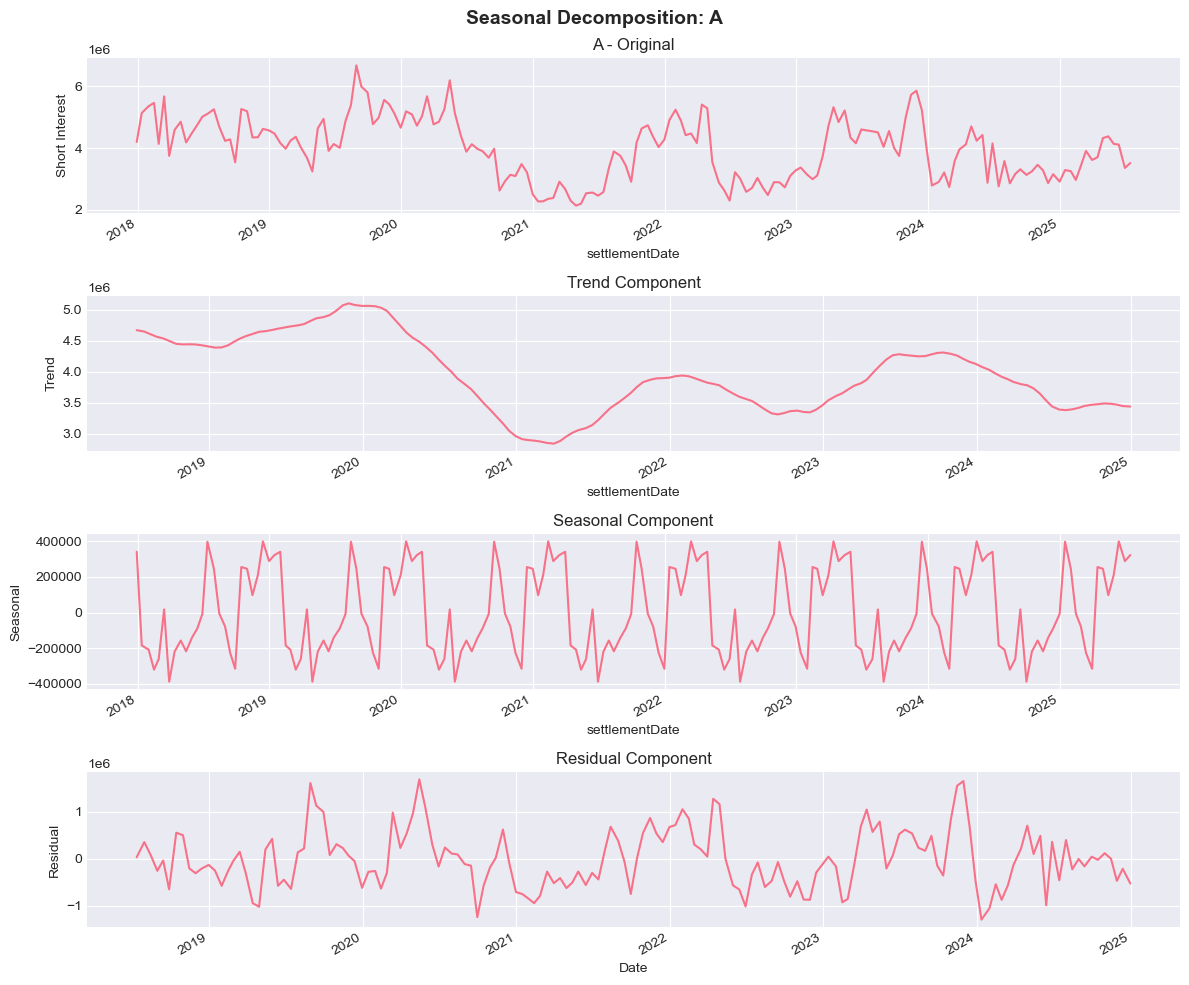

In [51]:
def perform_decomposition(series, stock_name, period=None):
    """
    Perform seasonal decomposition if sufficient data.
    """
    clean_series = series.dropna()
    
    # Need at least 2 full cycles for decomposition
    if period is None:
        period = 26  # Approximately yearly for bi-weekly data
    
    if len(clean_series) < 2 * period:
        print(f"Insufficient data for decomposition of {stock_name} (need {2*period} observations)")
        return None
    
    # Perform decomposition
    decomposition = seasonal_decompose(clean_series, model='additive', period=period)
    
    # Plot
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))
    
    clean_series.plot(ax=axes[0], title=f'{stock_name} - Original')
    axes[0].set_ylabel('Short Interest')
    
    decomposition.trend.plot(ax=axes[1], title='Trend Component')
    axes[1].set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
    axes[2].set_ylabel('Seasonal')
    
    decomposition.resid.plot(ax=axes[3], title='Residual Component')
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Date')
    
    plt.suptitle(f'Seasonal Decomposition: {stock_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return decomposition

# Perform decomposition for stock with most data
most_data_stock = data_coverage.index[0]
if data_coverage.iloc[0] >= 52:  # At least 2 years of bi-weekly data
    decomp = perform_decomposition(short_interest[most_data_stock], most_data_stock)


In [53]:
# Calculate time series characteristics for all valid stocks
ts_characteristics = []

for stock in valid_stocks:  
    series = short_interest[stock].dropna()
    
    if len(series) >= 30:
        # Basic stats
        char = {
            'stock': stock,
            'n_obs': len(series),
            'mean': series.mean(),
            'std': series.std(),
            'cv': series.std() / series.mean() if series.mean() != 0 else np.nan,
            'skewness': series.skew(),
            'kurtosis': series.kurtosis(),
            'nunique': series.nunique()
        }
        
        # Check if constant
        if series.nunique() == 1 or series.std() == 0:
            char['is_constant'] = True
            char['is_stationary'] = False
            char['adf_pvalue'] = np.nan
            char['acf_lag1'] = np.nan
            char['trend_slope'] = 0
            char['trend_direction'] = 'constant'
        else:
            char['is_constant'] = False
            
            try:
                # Stationarity
                adf_p = adfuller(series)[1]
                char['adf_pvalue'] = adf_p
                char['is_stationary'] = adf_p < 0.05
            except:
                char['adf_pvalue'] = np.nan
                char['is_stationary'] = False
            
            try:
                # Autocorrelation at lag 1
                if len(series) > 1:
                    char['acf_lag1'] = acf(series, nlags=1)[1]
            except:
                char['acf_lag1'] = np.nan
            
            # Trend (simple linear regression slope)
            x = np.arange(len(series))
            slope, intercept = np.polyfit(x, series.values, 1)
            char['trend_slope'] = slope
            char['trend_direction'] = 'increasing' if slope > 0 else 'decreasing'
        
        ts_characteristics.append(char)

ts_char_df = pd.DataFrame(ts_characteristics)

print("\nTIME SERIES CHARACTERISTICS SUMMARY")
print("=" * 60)
print(f"Stocks analyzed: {len(ts_char_df)}")

if 'is_constant' in ts_char_df.columns:
    print(f"\nConstant Series:")
    print(f"  Constant (no variation): {ts_char_df['is_constant'].sum()} ({ts_char_df['is_constant'].mean()*100:.1f}%)")

print(f"\nStationarity:")
print(f"  Stationary: {ts_char_df['is_stationary'].sum()} ({ts_char_df['is_stationary'].mean()*100:.1f}%)")
print(f"  Non-stationary: {(~ts_char_df['is_stationary']).sum()} ({(~ts_char_df['is_stationary']).mean()*100:.1f}%)")

# Filter out constant series for trend analysis
non_constant_df = ts_char_df[~ts_char_df['is_constant']] if 'is_constant' in ts_char_df.columns else ts_char_df

print(f"\nTrend Direction (excluding constant series):")
print(f"  Increasing: {(non_constant_df['trend_direction'] == 'increasing').sum()}")
print(f"  Decreasing: {(non_constant_df['trend_direction'] == 'decreasing').sum()}")

print(f"\nAutocorrelation at Lag 1 (excluding constant series):")
acf_clean = non_constant_df['acf_lag1'].dropna()
if len(acf_clean) > 0:
    print(f"  Mean: {acf_clean.mean():.3f}")
    print(f"  Median: {acf_clean.median():.3f}")
    print(f"  % with significant AC (>0.5): {(acf_clean.abs() > 0.5).mean()*100:.1f}%")

print("\nTop 10 Most Trending Stocks (by absolute slope, excluding constant):")
non_constant_df['abs_slope'] = non_constant_df['trend_slope'].abs()
print(non_constant_df.nlargest(10, 'abs_slope')[['stock', 'trend_slope', 'trend_direction', 'n_obs']])


TIME SERIES CHARACTERISTICS SUMMARY
Stocks analyzed: 30177

Constant Series:
  Constant (no variation): 154 (0.5%)

Stationarity:
  Stationary: 14809 (49.1%)
  Non-stationary: 15368 (50.9%)

Trend Direction (excluding constant series):
  Increasing: 15729
  Decreasing: 14294

Autocorrelation at Lag 1 (excluding constant series):
  Mean: 0.621
  Median: 0.707
  % with significant AC (>0.5): 67.3%

Top 10 Most Trending Stocks (by absolute slope, excluding constant):
       stock   trend_slope trend_direction  n_obs
20191  SNTMF  3.148739e+06      increasing     67
27280  ABPGF -3.064623e+06      decreasing     39
15019   LCID  3.056701e+06      increasing     96
4465   TIAOF  2.440535e+06      increasing    182
20169   PRPM -2.417494e+06      decreasing     67
29235    WFT -2.186020e+06      decreasing     33
25021   PRMO -1.840550e+06      decreasing     46
17963   SOUN  1.741015e+06      increasing     78
9239     CHK -1.692111e+06      decreasing    148
29625  BJECF  1.675819e+06    